# Capstone - Quillayute and Port Hardy Ballon Station Data Cleaning
Date: 2021.11.07<br>
William Matthews

## Introduction

This report documents the cleaning and imputation of weather ballon flight data from Quillayute and Port Hardy weather stations.  Initially, two csv files were produced in early November 2021 for use in EDA and intial model building in another report.  This process revealed a need to return to this note book and modify the approach to ensure a more comprehensive combined data set with fewer missing values.  The Quillayute station data was used as a base and its missing values imputed with the Port Hardy dataset.  This produced one final csv file which is used in the final feature engineering and modelling.

### Data Sets

We will be working with two data sets in this report.  Previously, we had scraped weather ballon data for two ballon sites, one at Quillayute and one at Port Hardy, limiting our data collection to the dates of our ski seasons as defined in our PowDayDataCleaning Report.  There are two ballon flights per day for each weather station.  For each flight, we gathered between 1 to 6 records of data around the 700 millibar/3,000m elevation.  The number of records collected depended on the number of data points available bewteen 670 millibar and 730 millibar.  Each data set contains both missing values on individual flights, as well as missing days where there is no data at all.

### Report Objectives and Flow

This report's primary objective is to outline the data cleaning process for the Quillayute and Port Hardy Weather Ballon Station Data.  The rough plan is as follows:
- For each Weather Station:
    - Confirm we have the appropriate dates
    - Identify any rows with missing data
        - Shift data to correct columns if possible (the scraping process was not perfect!)
        - If missing data is in columns of interest, explore dropping or imputing
            - Drop/impute as needed
    - Drop columns that are not of interest
    - Check for duplicates and drop as neccessary
    - Compress multiple soundings for a specific datetime into some sort of aggregated measure
    - Write to csv

### Libraries and Imports

In [1]:
# managing data
import pandas as pd
import numpy as np

# managing time
from datetime import datetime
from datetime import timedelta

# plotting data
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for timeseries EDA
from statsmodels.api import tsa
import statsmodels.api as sm

In [2]:
q_df = pd.read_csv('./Data/BallonData/Quillayute.csv')

In [3]:
ph_df = pd.read_csv('./Data/BallonData/Port Hardy.csv')

## Port Hardy Station

### Data Exploration

Let's start out with a high level look at our data.

In [4]:
display(ph_df.info(),
        ph_df.head(),
        ph_df.shape,
        ph_df.isna().sum().sum() / ph_df.shape[0]) # calculate % of rows with NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8838 entries, 0 to 8837
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    8838 non-null   object 
 1   PRES    8838 non-null   float64
 2   HGHT    8838 non-null   int64  
 3   TEMP    8838 non-null   float64
 4   DWPT    8838 non-null   float64
 5   RELH    8838 non-null   int64  
 6   MIXR    8838 non-null   float64
 7   DRCT    8838 non-null   float64
 8   SKNT    8827 non-null   float64
 9   THTA    8827 non-null   float64
 10  THTE    8813 non-null   float64
 11  THTV    8813 non-null   float64
 12  STNM    8838 non-null   object 
dtypes: float64(9), int64(2), object(2)
memory usage: 897.7+ KB


None

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0  2014-12-31 16:00:00  724.0  2899  -1.7  -5.3    76  3.58  351.0  25.0   
1  2014-12-31 16:00:00  714.0  3010  -1.9  -6.6    70  3.28  344.0  25.0   
2  2014-12-31 16:00:00  703.0  3134  -1.1 -10.1    50  2.54  337.0  26.0   
3  2014-12-31 16:00:00  700.0  3168  -1.3 -11.3    47  2.31  335.0  26.0   
4  2014-12-31 16:00:00  699.0  3179  -1.3 -11.3    47  2.32  333.0  26.0   

    THTA   THTE   THTV        STNM  
0  297.7  308.6  298.3  Port Hardy  
1  298.7  308.8  299.2  Port Hardy  
2  300.9  308.9  301.3  Port Hardy  
3  301.0  308.4  301.4  Port Hardy  
4  301.1  308.5  301.6  Port Hardy

(8838, 13)

0.008146639511201629

From the above it look like we have 8,838 rows across 13 columns.  Several columns have some missing values, but calculated by rows, this accounts for less than 1% of our data.  We will address this shortly.  The data appears to be what is expected based on the first 5 rows.  Data types are all as expected.  Since we might do some manipulation on the `DATE` column, we will change it to a date time.  We will do a quick check to make sure the first and last dates match our known date range first (01 Jan 2015 through 17 Apr 2021).

In [5]:
print(f"First Date: {ph_df.iloc[0, :]['DATE']}")
print(f"Last Date: {ph_df.iloc[-1, :]['DATE']}")

First Date: 2014-12-31 16:00:00
Last Date: 2021-04-30 04:00:00


From the above it looks like the first date matches our expectations (the night before our first target date).  The ending date is a little past our ending date of 17 Apr 2021.  Let's go ahead and convert the column to datetime and then drop the records that are later than 17 Apr 2021.

In [6]:
# convert column to date time
ph_df['DATE'] = pd.to_datetime(ph_df['DATE'] )

# confirm it worked
ph_df['DATE'].dtypes

dtype('<M8[ns]')

Now that we have the `DATE` column as datetime objects, let's move ahead and drop the records outside our time range

In [7]:
# get the indicies of rows with dates past our last date
past_indicies = ph_df[ph_df['DATE'] > datetime(2021, 4, 17)].index

# confirm this drop is going to do what we want it to by checking the max date after drop
(ph_df.drop(index = past_indicies)['DATE'].max() < datetime(2021, 4, 18))

True

In [8]:
# drop the additional rows
ph_df1 = ph_df.drop(index = past_indicies).copy()

# confirm
display(ph_df1['DATE'].max() < datetime(2021, 4, 18))

# double check
display(ph_df1.iloc[-1, :])

True

DATE    2021-04-16 16:00:00
PRES                  682.4
HGHT                   3353
TEMP                   -1.2
DWPT                  -18.2
RELH                     26
MIXR                   1.34
DRCT                   95.0
SKNT                   13.0
THTA                  303.4
THTE                  307.8
THTV                  303.6
STNM             Port Hardy
Name: 8763, dtype: object

### Data Exploration - Column Shifting

With the data outside of our time range removed let's move onto the rows with missing values.  We know that when we scraped the data from the website that a few records were missing various columns.  The scraping algorithem dealt with this by simply shifting all values to the left most empty columns.  Let's take a look at all of the rows missing data (only 25) to make sure nothing strange is going on.  We will also bring up a few rows of good data for comparison.

In [9]:
display(ph_df1[ph_df1.isna().any(axis = 1)])
display(ph_df1.head())

DATE   PRES  HGHT  TEMP   DWPT  RELH    MIXR   DRCT  \
488  2015-02-25 04:00:00  704.2  3048  -5.0  265.0    15  296.40  296.4   
489  2015-02-25 04:00:00  700.0  3095  -5.3  275.0    14  296.60  296.6   
490  2015-02-25 04:00:00  698.0  3117  -5.5  276.0    15  296.60  296.6   
491  2015-02-25 04:00:00  677.2  3353  -6.3  285.0    23  298.30  298.3   
2451 2016-11-08 16:00:00  720.9  2743  -1.3  190.0    45  298.50  298.5   
2452 2016-11-08 16:00:00  700.0  2978  -2.3  185.0    50  299.90  299.9   
2453 2016-11-08 16:00:00  693.8  3048  -2.7  185.0    48  300.30  300.3   
2666 2016-12-01 16:00:00  700.0  3003  -9.3  -34.3    11    0.30  292.2   
2851 2016-12-26 16:00:00  715.0  2712  -9.3   -9.3   100    2.66  290.4   
2852 2016-12-26 16:00:00  703.0  2843 -11.3  -11.9    95    2.20  289.6   
2853 2016-12-26 16:00:00  688.0  3007 -13.9  -26.9    32    0.62  288.5   
2854 2016-12-26 16:00:00  686.0  3029 -14.1  -26.1    36    0.67  288.5   
2855 2016-12-26 16:00:00  676.0  3141 -14.5  -24.5    42    0.78  289.3   
3539 2017-03-18 04:00:00  724.0  2567 -13.3  -13.5    98    1.87  285.0   
3540 2017-03-18 04:00:00  700.0  2823 -14.9  -15.1    98    1.70  286.0   
3541 2017-03-18 04:00:00  672.0  3132 -16.5  -17.0    96    1.51  287.5   
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0    54  297.80  297.8   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0    60  299.00  299.0   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0    56  299.70  299.7   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0    52  300.10  300.1   
5462 2018-11-01 16:00:00  683.0  3195  -0.7   -0.7   100    5.35  303.8   
6076 2019-02-01 04:00:00  707.0  2750  -7.7   -9.4    88    2.66  293.1   
6314 2019-03-10 16:00:00  689.0  3113 -10.1  -12.2    85    2.19  292.6   
6315 2019-03-10 16:00:00  685.0  3156  -9.7  -11.7    85    2.29  293.5   
6424 2019-03-29 04:00:00  698.0  3093 -10.5  -14.8    71    1.75  291.1   

       SKNT   THTA  THTE  THTV        STNM  
488     NaN    NaN   NaN   NaN  Port Hardy  
489     NaN    NaN   NaN   NaN  Port Hardy  
490     NaN    NaN   NaN   NaN  Port Hardy  
491     NaN    NaN   NaN   NaN  Port Hardy  
2451    NaN    NaN   NaN   NaN  Port Hardy  
2452    NaN    NaN   NaN   NaN  Port Hardy  
2453    NaN    NaN   NaN   NaN  Port Hardy  
2666  293.2  292.2   NaN   NaN  Port Hardy  
2851  298.4  290.9   NaN   NaN  Port Hardy  
2852  296.3  290.0   NaN   NaN  Port Hardy  
2853  290.5  288.6   NaN   NaN  Port Hardy  
2854  290.7  288.6   NaN   NaN  Port Hardy  
2855  291.8  289.4   NaN   NaN  Port Hardy  
3539  290.6  285.3   NaN   NaN  Port Hardy  
3540  291.1  286.2   NaN   NaN  Port Hardy  
3541  292.2  287.8   NaN   NaN  Port Hardy  
3700    NaN    NaN   NaN   NaN  Port Hardy  
3701    NaN    NaN   NaN   NaN  Port Hardy  
3702    NaN    NaN   NaN   NaN  Port Hardy  
3703    NaN    NaN   NaN   NaN  Port Hardy  
5462  320.3  304.8   NaN   NaN  Port Hardy  
6076  301.2  293.6   NaN   NaN  Port Hardy  
6314  299.3  293.0   NaN   NaN  Port Hardy  
6315  300.6  293.9   NaN   NaN  Port Hardy  
6424  296.5  291.4   NaN   NaN  Port Hardy

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0 2014-12-31 16:00:00  724.0  2899  -1.7  -5.3    76  3.58  351.0  25.0   
1 2014-12-31 16:00:00  714.0  3010  -1.9  -6.6    70  3.28  344.0  25.0   
2 2014-12-31 16:00:00  703.0  3134  -1.1 -10.1    50  2.54  337.0  26.0   
3 2014-12-31 16:00:00  700.0  3168  -1.3 -11.3    47  2.31  335.0  26.0   
4 2014-12-31 16:00:00  699.0  3179  -1.3 -11.3    47  2.32  333.0  26.0   

    THTA   THTE   THTV        STNM  
0  297.7  308.6  298.3  Port Hardy  
1  298.7  308.8  299.2  Port Hardy  
2  300.9  308.9  301.3  Port Hardy  
3  301.0  308.4  301.4  Port Hardy  
4  301.1  308.5  301.6  Port Hardy

Two of the key variables of interst are `DRCT` (wind direction) and `SKNT` (speed in knots) so it is unfortunate they have been effected.  `THTA, THTE,` and `THTV` are not of interest to us, so we are not worried about them.  The trouble with simply deleting these records is that we only have two times of measurement per day, and relatively few soundings for each datetime, so simply deleting them will leave holes in our record.  Let's grab each unique datetime and then see if we can impute the values.  This may take some manual research to get the sounding data we omitted from our webscraping!

First thing to do is get all the NaN records into a smaller data frame to work with.  We will deal with each date one by one.

_Personal Note: Roughlyl 1 hr to this point_

In [10]:
# get nan records
nans_df = ph_df1[ph_df1.isna().any(axis = 1)]

# confirm it worked
nans_df

DATE   PRES  HGHT  TEMP   DWPT  RELH    MIXR   DRCT  \
488  2015-02-25 04:00:00  704.2  3048  -5.0  265.0    15  296.40  296.4   
489  2015-02-25 04:00:00  700.0  3095  -5.3  275.0    14  296.60  296.6   
490  2015-02-25 04:00:00  698.0  3117  -5.5  276.0    15  296.60  296.6   
491  2015-02-25 04:00:00  677.2  3353  -6.3  285.0    23  298.30  298.3   
2451 2016-11-08 16:00:00  720.9  2743  -1.3  190.0    45  298.50  298.5   
2452 2016-11-08 16:00:00  700.0  2978  -2.3  185.0    50  299.90  299.9   
2453 2016-11-08 16:00:00  693.8  3048  -2.7  185.0    48  300.30  300.3   
2666 2016-12-01 16:00:00  700.0  3003  -9.3  -34.3    11    0.30  292.2   
2851 2016-12-26 16:00:00  715.0  2712  -9.3   -9.3   100    2.66  290.4   
2852 2016-12-26 16:00:00  703.0  2843 -11.3  -11.9    95    2.20  289.6   
2853 2016-12-26 16:00:00  688.0  3007 -13.9  -26.9    32    0.62  288.5   
2854 2016-12-26 16:00:00  686.0  3029 -14.1  -26.1    36    0.67  288.5   
2855 2016-12-26 16:00:00  676.0  3141 -14.5  -24.5    42    0.78  289.3   
3539 2017-03-18 04:00:00  724.0  2567 -13.3  -13.5    98    1.87  285.0   
3540 2017-03-18 04:00:00  700.0  2823 -14.9  -15.1    98    1.70  286.0   
3541 2017-03-18 04:00:00  672.0  3132 -16.5  -17.0    96    1.51  287.5   
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0    54  297.80  297.8   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0    60  299.00  299.0   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0    56  299.70  299.7   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0    52  300.10  300.1   
5462 2018-11-01 16:00:00  683.0  3195  -0.7   -0.7   100    5.35  303.8   
6076 2019-02-01 04:00:00  707.0  2750  -7.7   -9.4    88    2.66  293.1   
6314 2019-03-10 16:00:00  689.0  3113 -10.1  -12.2    85    2.19  292.6   
6315 2019-03-10 16:00:00  685.0  3156  -9.7  -11.7    85    2.29  293.5   
6424 2019-03-29 04:00:00  698.0  3093 -10.5  -14.8    71    1.75  291.1   

       SKNT   THTA  THTE  THTV        STNM  
488     NaN    NaN   NaN   NaN  Port Hardy  
489     NaN    NaN   NaN   NaN  Port Hardy  
490     NaN    NaN   NaN   NaN  Port Hardy  
491     NaN    NaN   NaN   NaN  Port Hardy  
2451    NaN    NaN   NaN   NaN  Port Hardy  
2452    NaN    NaN   NaN   NaN  Port Hardy  
2453    NaN    NaN   NaN   NaN  Port Hardy  
2666  293.2  292.2   NaN   NaN  Port Hardy  
2851  298.4  290.9   NaN   NaN  Port Hardy  
2852  296.3  290.0   NaN   NaN  Port Hardy  
2853  290.5  288.6   NaN   NaN  Port Hardy  
2854  290.7  288.6   NaN   NaN  Port Hardy  
2855  291.8  289.4   NaN   NaN  Port Hardy  
3539  290.6  285.3   NaN   NaN  Port Hardy  
3540  291.1  286.2   NaN   NaN  Port Hardy  
3541  292.2  287.8   NaN   NaN  Port Hardy  
3700    NaN    NaN   NaN   NaN  Port Hardy  
3701    NaN    NaN   NaN   NaN  Port Hardy  
3702    NaN    NaN   NaN   NaN  Port Hardy  
3703    NaN    NaN   NaN   NaN  Port Hardy  
5462  320.3  304.8   NaN   NaN  Port Hardy  
6076  301.2  293.6   NaN   NaN  Port Hardy  
6314  299.3  293.0   NaN   NaN  Port Hardy  
6315  300.6  293.9   NaN   NaN  Port Hardy  
6424  296.5  291.4   NaN   NaN  Port Hardy

In [11]:
# show the first date only vs the good data
print("Bad Data")
display(nans_df[nans_df['DATE'] == datetime(2015, 2, 25, 4)])
print()
print("Good Data")
display(ph_df1.head())

Bad Data


DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR   DRCT  SKNT  \
488 2015-02-25 04:00:00  704.2  3048  -5.0  265.0    15  296.4  296.4   NaN   
489 2015-02-25 04:00:00  700.0  3095  -5.3  275.0    14  296.6  296.6   NaN   
490 2015-02-25 04:00:00  698.0  3117  -5.5  276.0    15  296.6  296.6   NaN   
491 2015-02-25 04:00:00  677.2  3353  -6.3  285.0    23  298.3  298.3   NaN   

     THTA  THTE  THTV        STNM  
488   NaN   NaN   NaN  Port Hardy  
489   NaN   NaN   NaN  Port Hardy  
490   NaN   NaN   NaN  Port Hardy  
491   NaN   NaN   NaN  Port Hardy


Good Data


DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0 2014-12-31 16:00:00  724.0  2899  -1.7  -5.3    76  3.58  351.0  25.0   
1 2014-12-31 16:00:00  714.0  3010  -1.9  -6.6    70  3.28  344.0  25.0   
2 2014-12-31 16:00:00  703.0  3134  -1.1 -10.1    50  2.54  337.0  26.0   
3 2014-12-31 16:00:00  700.0  3168  -1.3 -11.3    47  2.31  335.0  26.0   
4 2014-12-31 16:00:00  699.0  3179  -1.3 -11.3    47  2.32  333.0  26.0   

    THTA   THTE   THTV        STNM  
0  297.7  308.6  298.3  Port Hardy  
1  298.7  308.8  299.2  Port Hardy  
2  300.9  308.9  301.3  Port Hardy  
3  301.0  308.4  301.4  Port Hardy  
4  301.1  308.5  301.6  Port Hardy

It looks like this data is saveable.  From visual inspection of the above, `DWPT` should be `DRCT`, and that would turn `RELH` into `SKNT`.  To confirm this, let's check the stats on these columns to see if this makes sense.  To do this, we are going to create a temporary data frame with all of the NaN rows removed. This will allow us to get true min/max values and that will help identify how we should shift the columns.

In [12]:
# drop any row with a null value to create our temp df
nulless_df = ph_df1.dropna()

# confirm it worked properly by comparing shapes of the dfs we have generated
display(ph_df1.shape[0] - nans_df.shape[0] == nulless_df.shape[0]) 

# get the stats on the data we know is good.
nulless_df[['DWPT', 'RELH', 'MIXR', 'DRCT', 'SKNT']].describe()

True

DWPT         RELH         MIXR         DRCT         SKNT
count  8739.000000  8739.000000  8739.000000  8739.000000  8739.000000
mean    -19.590914    55.122096     1.551814   223.898272    25.080101
std      10.626383    31.161502     1.089403    76.052329    13.592649
min     -58.700000     1.000000     0.020000     0.000000     0.000000
25%     -25.100000    27.000000     0.720000   185.000000    15.000000
50%     -17.600000    58.000000     1.370000   226.000000    23.000000
75%     -12.100000    84.000000     2.150000   276.000000    33.000000
max       1.600000   100.000000     5.970000   360.000000    90.000000

Comparing the above table of clean column statistics to our four rows on the 25th of February, we can clearly see values around 275 for `DWPT` make no sense.  Shifting things to the right one column at a time, those values also do not fit in the `RELH` column or the `MIXR` column.  After a third shift to the right they do fit very well into the `DRCT` column.  Looking again at the rows on the 25th of February, the values in `RELH`, if also shifted three columns to the right, fall into the `SKNT` column and these values would fit there nicely.  Based on this we are going to move `DWPT` to `DRCT` and `RELH` to `SKNT` for each row on the 25th of Feb.

In [13]:
def shift_value(source, target, row, df):
    """
    Takes a source column, target column, row, and a dataFrame.  Moves the source column
    to the target column and puts a NaN value into the source column.
    ______________
    
    PARAMETERS:
                source: a string, representing the column to move information from
                target: a string, representing the column to move information to
                   row: an int, the index number of the row to do the operation on
                    df: a pandas dataFrame, the object to do the moving on
    _____________
    
    RETURNS:
                None            
    
    """
    # move source to target
    df.loc[row, target] = df.loc[row, source]
    
    # replace source with NaN
    df.loc[row, source] = np.nan

In [14]:
# get indicies of rows we need to change by visual inspection
indicies = [488,489,490,491]

# loop through indicies
for row in indicies:
    # apply changes to nans_df first to check they do what we want and test the shift_value() function
    
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, nans_df)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, nans_df)

# print out to make sure it works!
nans_df.head(4)

/home/william/anaconda3/envs/plotly_bokeh/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
488 2015-02-25 04:00:00  704.2  3048  -5.0   NaN   NaN  296.4  265.0  15.0   
489 2015-02-25 04:00:00  700.0  3095  -5.3   NaN   NaN  296.6  275.0  14.0   
490 2015-02-25 04:00:00  698.0  3117  -5.5   NaN   NaN  296.6  276.0  15.0   
491 2015-02-25 04:00:00  677.2  3353  -6.3   NaN   NaN  298.3  285.0  23.0   

     THTA  THTE  THTV        STNM  
488   NaN   NaN   NaN  Port Hardy  
489   NaN   NaN   NaN  Port Hardy  
490   NaN   NaN   NaN  Port Hardy  
491   NaN   NaN   NaN  Port Hardy

Looks like the above is working well.  One issue is that we have now created `NaN` values in columns where we would like data.  We can probably impute these values if we examine the entire flight worth of data from the original data source.  We will get to that later.  For now, we are going to do all the column shifting we can based on the info we have.  Let's make the changes in our primary data frame and then move onto the next dates.

In [15]:
# get indicies of rows we need to change by visual inspection
indicies = [488,489,490,491]

# loop through indicies
for row in indicies:
    # apply changes to nans_df first to check they do what we want and test the shift_value() function
    
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, ph_df1)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, ph_df1)
    
    # print out to confirm changes
    print(ph_df1.loc[row, :])

DATE    2015-02-25 04:00:00
PRES                  704.2
HGHT                   3048
TEMP                   -5.0
DWPT                    NaN
RELH                    NaN
MIXR                  296.4
DRCT                  265.0
SKNT                   15.0
THTA                    NaN
THTE                    NaN
THTV                    NaN
STNM             Port Hardy
Name: 488, dtype: object
DATE    2015-02-25 04:00:00
PRES                  700.0
HGHT                   3095
TEMP                   -5.3
DWPT                    NaN
RELH                    NaN
MIXR                  296.6
DRCT                  275.0
SKNT                   14.0
THTA                    NaN
THTE                    NaN
THTV                    NaN
STNM             Port Hardy
Name: 489, dtype: object
DATE    2015-02-25 04:00:00
PRES                  698.0
HGHT                   3117
TEMP                   -5.5
DWPT                    NaN
RELH                    NaN
MIXR                  296.6
DRCT                  276.

In [16]:
# get a list of each unique datetime in our nans_df
nans_datetimes = nans_df['DATE'].unique()

# change to list - we will pop the first element off this list each time we complete a transformation on a given datetime set of lines
nans_datetimes = list(nans_datetimes)

# pop the first element as we have completed the transformation above
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 25 Feb at the head
nans_datetimes

[numpy.datetime64('2016-11-08T16:00:00.000000000'),
 numpy.datetime64('2016-12-01T16:00:00.000000000'),
 numpy.datetime64('2016-12-26T16:00:00.000000000'),
 numpy.datetime64('2017-03-18T04:00:00.000000000'),
 numpy.datetime64('2017-04-04T16:00:00.000000000'),
 numpy.datetime64('2018-11-01T16:00:00.000000000'),
 numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

Let's get a look at the next date on our list.  We are going to start doing this by date matching instead of using are nans_df.  Seems like a silly approach to be managing two data frames now that we know our shifting operation works.

In [17]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR   DRCT  SKNT  \
2451 2016-11-08 16:00:00  720.9  2743  -1.3  190.0  45.0  298.5  298.5   NaN   
2452 2016-11-08 16:00:00  700.0  2978  -2.3  185.0  50.0  299.9  299.9   NaN   
2453 2016-11-08 16:00:00  693.8  3048  -2.7  185.0  48.0  300.3  300.3   NaN   

      THTA  THTE  THTV        STNM  
2451   NaN   NaN   NaN  Port Hardy  
2452   NaN   NaN   NaN  Port Hardy  
2453   NaN   NaN   NaN  Port Hardy

Visually inspecting the above, it looks like we have the same pattern as Feb 25th.  We are going to shift column values as before.

In [18]:
# get indicies of rows we need to change by visual inspection
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through indicies
for row in indicies:

    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, ph_df1)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, ph_df1)

# check it worked
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
2451 2016-11-08 16:00:00  720.9  2743  -1.3   NaN   NaN  298.5  190.0  45.0   
2452 2016-11-08 16:00:00  700.0  2978  -2.3   NaN   NaN  299.9  185.0  50.0   
2453 2016-11-08 16:00:00  693.8  3048  -2.7   NaN   NaN  300.3  185.0  48.0   

      THTA  THTE  THTV        STNM  
2451   NaN   NaN   NaN  Port Hardy  
2452   NaN   NaN   NaN  Port Hardy  
2453   NaN   NaN   NaN  Port Hardy

In [19]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 08 Nov at the head
nans_datetimes

[numpy.datetime64('2016-12-01T16:00:00.000000000'),
 numpy.datetime64('2016-12-26T16:00:00.000000000'),
 numpy.datetime64('2017-03-18T04:00:00.000000000'),
 numpy.datetime64('2017-04-04T16:00:00.000000000'),
 numpy.datetime64('2018-11-01T16:00:00.000000000'),
 numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

Moving onto the next date in our list.

In [20]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
2666 2016-12-01 16:00:00  700.0  3003  -9.3 -34.3  11.0   0.3  292.2  293.2   

       THTA  THTE  THTV        STNM  
2666  292.2   NaN   NaN  Port Hardy

This looks like two values were missing (`DRCT` and `SKNT`) and the `THTx` values have shifted to the left.  We are going to put NaN values into the `DRCT` and `SKNT` as we will have to address these later.  We are not worried about the `THTx` columns as we will drop these later.

In [21]:
# put NaNs in columns we will want to address later
ph_df1.loc[2666, 'DRCT'] = np.nan
ph_df1.loc[2666, 'SKNT'] = np.nan

# check it worked
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
2666 2016-12-01 16:00:00  700.0  3003  -9.3 -34.3  11.0   0.3   NaN   NaN   

       THTA  THTE  THTV        STNM  
2666  292.2   NaN   NaN  Port Hardy

In [22]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 01 Dec  at the head
nans_datetimes

[numpy.datetime64('2016-12-26T16:00:00.000000000'),
 numpy.datetime64('2017-03-18T04:00:00.000000000'),
 numpy.datetime64('2017-04-04T16:00:00.000000000'),
 numpy.datetime64('2018-11-01T16:00:00.000000000'),
 numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

Moving onto the next date on our list.

In [23]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT   RELH  MIXR   DRCT   SKNT  \
2851 2016-12-26 16:00:00  715.0  2712  -9.3  -9.3  100.0  2.66  290.4  298.4   
2852 2016-12-26 16:00:00  703.0  2843 -11.3 -11.9   95.0  2.20  289.6  296.3   
2853 2016-12-26 16:00:00  688.0  3007 -13.9 -26.9   32.0  0.62  288.5  290.5   
2854 2016-12-26 16:00:00  686.0  3029 -14.1 -26.1   36.0  0.67  288.5  290.7   
2855 2016-12-26 16:00:00  676.0  3141 -14.5 -24.5   42.0  0.78  289.3  291.8   

       THTA  THTE  THTV        STNM  
2851  290.9   NaN   NaN  Port Hardy  
2852  290.0   NaN   NaN  Port Hardy  
2853  288.6   NaN   NaN  Port Hardy  
2854  288.6   NaN   NaN  Port Hardy  
2855  289.4   NaN   NaN  Port Hardy

In [24]:
# get the stats on the data we know is good.
nulless_df[['DWPT', 'RELH', 'MIXR', 'DRCT', 'SKNT']].describe()

DWPT         RELH         MIXR         DRCT         SKNT
count  8739.000000  8739.000000  8739.000000  8739.000000  8739.000000
mean    -19.590914    55.122096     1.551814   223.898272    25.080101
std      10.626383    31.161502     1.089403    76.052329    13.592649
min     -58.700000     1.000000     0.020000     0.000000     0.000000
25%     -25.100000    27.000000     0.720000   185.000000    15.000000
50%     -17.600000    58.000000     1.370000   226.000000    23.000000
75%     -12.100000    84.000000     2.150000   276.000000    33.000000
max       1.600000   100.000000     5.970000   360.000000    90.000000

Visual inspection of the above looks like we are missing the direction and speed columns unfortunatley.  Let's put NaN values into those to deal with later.

In [25]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'DRCT'] = np.nan
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT   RELH  MIXR  DRCT  SKNT  \
2851 2016-12-26 16:00:00  715.0  2712  -9.3  -9.3  100.0  2.66   NaN   NaN   
2852 2016-12-26 16:00:00  703.0  2843 -11.3 -11.9   95.0  2.20   NaN   NaN   
2853 2016-12-26 16:00:00  688.0  3007 -13.9 -26.9   32.0  0.62   NaN   NaN   
2854 2016-12-26 16:00:00  686.0  3029 -14.1 -26.1   36.0  0.67   NaN   NaN   
2855 2016-12-26 16:00:00  676.0  3141 -14.5 -24.5   42.0  0.78   NaN   NaN   

       THTA  THTE  THTV        STNM  
2851  290.9   NaN   NaN  Port Hardy  
2852  290.0   NaN   NaN  Port Hardy  
2853  288.6   NaN   NaN  Port Hardy  
2854  288.6   NaN   NaN  Port Hardy  
2855  289.4   NaN   NaN  Port Hardy

In [26]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 01 Dec  at the head
nans_datetimes

[numpy.datetime64('2017-03-18T04:00:00.000000000'),
 numpy.datetime64('2017-04-04T16:00:00.000000000'),
 numpy.datetime64('2018-11-01T16:00:00.000000000'),
 numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

On to the next elements in the list

In [27]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
3539 2017-03-18 04:00:00  724.0  2567 -13.3 -13.5  98.0  1.87  285.0  290.6   
3540 2017-03-18 04:00:00  700.0  2823 -14.9 -15.1  98.0  1.70  286.0  291.1   
3541 2017-03-18 04:00:00  672.0  3132 -16.5 -17.0  96.0  1.51  287.5  292.2   

       THTA  THTE  THTV        STNM  
3539  285.3   NaN   NaN  Port Hardy  
3540  286.2   NaN   NaN  Port Hardy  
3541  287.8   NaN   NaN  Port Hardy

In [28]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'DRCT'] = np.nan
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
3539 2017-03-18 04:00:00  724.0  2567 -13.3 -13.5  98.0  1.87   NaN   NaN   
3540 2017-03-18 04:00:00  700.0  2823 -14.9 -15.1  98.0  1.70   NaN   NaN   
3541 2017-03-18 04:00:00  672.0  3132 -16.5 -17.0  96.0  1.51   NaN   NaN   

       THTA  THTE  THTV        STNM  
3539  285.3   NaN   NaN  Port Hardy  
3540  286.2   NaN   NaN  Port Hardy  
3541  287.8   NaN   NaN  Port Hardy

In [29]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 18 Mar  at the head
nans_datetimes

[numpy.datetime64('2017-04-04T16:00:00.000000000'),
 numpy.datetime64('2018-11-01T16:00:00.000000000'),
 numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

Rinse and repeat until we are through the list!

In [30]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR   DRCT  SKNT  \
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0  54.0  297.8  297.8   NaN   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0  60.0  299.0  299.0   NaN   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0  56.0  299.7  299.7   NaN   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0  52.0  300.1  300.1   NaN   

      THTA  THTE  THTV        STNM  
3700   NaN   NaN   NaN  Port Hardy  
3701   NaN   NaN   NaN  Port Hardy  
3702   NaN   NaN   NaN  Port Hardy  
3703   NaN   NaN   NaN  Port Hardy

This looks intersting again.  Let's get the descriptive stats to check against again.

In [31]:
# get the stats on the data we know is good.
nulless_df[['DWPT', 'RELH', 'MIXR', 'DRCT', 'SKNT']].describe()

DWPT         RELH         MIXR         DRCT         SKNT
count  8739.000000  8739.000000  8739.000000  8739.000000  8739.000000
mean    -19.590914    55.122096     1.551814   223.898272    25.080101
std      10.626383    31.161502     1.089403    76.052329    13.592649
min     -58.700000     1.000000     0.020000     0.000000     0.000000
25%     -25.100000    27.000000     0.720000   185.000000    15.000000
50%     -17.600000    58.000000     1.370000   226.000000    23.000000
75%     -12.100000    84.000000     2.150000   276.000000    33.000000
max       1.600000   100.000000     5.970000   360.000000    90.000000

Similar to above, looks like direction and wind speed are missing.  Let's set them to NaN and move on.

In [32]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'DRCT'] = np.nan
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR  DRCT  SKNT  \
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0  54.0  297.8   NaN   NaN   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0  60.0  299.0   NaN   NaN   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0  56.0  299.7   NaN   NaN   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0  52.0  300.1   NaN   NaN   

      THTA  THTE  THTV        STNM  
3700   NaN   NaN   NaN  Port Hardy  
3701   NaN   NaN   NaN  Port Hardy  
3702   NaN   NaN   NaN  Port Hardy  
3703   NaN   NaN   NaN  Port Hardy

In [33]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 06 Apr  at the head
nans_datetimes

[numpy.datetime64('2018-11-01T16:00:00.000000000'),
 numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

In [34]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT   RELH  MIXR   DRCT   SKNT  \
5459 2018-11-01 16:00:00  722.4  2743   2.2   1.6   96.0  5.97  235.0   58.0   
5460 2018-11-01 16:00:00  700.0  2998   0.6   0.4   99.0  5.66  235.0   58.0   
5461 2018-11-01 16:00:00  695.6  3048   0.3   0.1   99.0  5.58  235.0   61.0   
5462 2018-11-01 16:00:00  683.0  3195  -0.7  -0.7  100.0  5.35  303.8  320.3   

       THTA   THTE   THTV        STNM  
5459  302.2  320.3  303.3  Port Hardy  
5460  303.1  320.4  304.1  Port Hardy  
5461  303.3  320.4  304.3  Port Hardy  
5462  304.8    NaN    NaN  Port Hardy

It looks like all the values we want to keep are good for this date.  It was only captured because of the `NaN` values in the last two `THTx` columns.  No transforms needed, so let's remove it from the list and continue on.

In [35]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 01 Nov  at the head
nans_datetimes

[numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

In [36]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
6076 2019-02-01 04:00:00  707.0  2750  -7.7  -9.4  88.0  2.66  293.1  301.2   

       THTA  THTE  THTV        STNM  
6076  293.6   NaN   NaN  Port Hardy

Looks like from the above we are only missing `SKNT`.  everything else appears to be in order.  Let's fix this up and leave it for imputation later.

In [37]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6076 2019-02-01 04:00:00  707.0  2750  -7.7  -9.4  88.0  2.66  293.1   NaN   

       THTA  THTE  THTV        STNM  
6076  293.6   NaN   NaN  Port Hardy

In [38]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 01 Feb at the head
nans_datetimes

[numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

In [39]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
6311 2019-03-10 16:00:00  723.0  2743  -8.4 -15.7  56.0  1.56  235.0   24.0   
6312 2019-03-10 16:00:00  700.0  2995  -9.9 -13.5  75.0  1.94  235.0   30.0   
6313 2019-03-10 16:00:00  695.0  3048 -10.0 -12.9  79.0  2.05  230.0   31.0   
6314 2019-03-10 16:00:00  689.0  3113 -10.1 -12.2  85.0  2.19  292.6  299.3   
6315 2019-03-10 16:00:00  685.0  3156  -9.7 -11.7  85.0  2.29  293.5  300.6   

       THTA   THTE   THTV        STNM  
6311  290.4  295.3  290.7  Port Hardy  
6312  291.5  297.5  291.8  Port Hardy  
6313  292.0  298.3  292.4  Port Hardy  
6314  293.0    NaN    NaN  Port Hardy  
6315  293.9    NaN    NaN  Port Hardy

It looks like only the last two records on this date re missing values, and for `SKNT` only.  Let's make them `NaN` and move on.

In [40]:
# get indicies of rows to work on - last two only!
indicies = list(ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index)[-2:]

# loop through last two rows only and set nan values
for i in indicies:
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6311 2019-03-10 16:00:00  723.0  2743  -8.4 -15.7  56.0  1.56  235.0  24.0   
6312 2019-03-10 16:00:00  700.0  2995  -9.9 -13.5  75.0  1.94  235.0  30.0   
6313 2019-03-10 16:00:00  695.0  3048 -10.0 -12.9  79.0  2.05  230.0  31.0   
6314 2019-03-10 16:00:00  689.0  3113 -10.1 -12.2  85.0  2.19  292.6   NaN   
6315 2019-03-10 16:00:00  685.0  3156  -9.7 -11.7  85.0  2.29  293.5   NaN   

       THTA   THTE   THTV        STNM  
6311  290.4  295.3  290.7  Port Hardy  
6312  291.5  297.5  291.8  Port Hardy  
6313  292.0  298.3  292.4  Port Hardy  
6314  293.0    NaN    NaN  Port Hardy  
6315  293.9    NaN    NaN  Port Hardy

In [41]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 10 Mar at the head
nans_datetimes

[numpy.datetime64('2019-03-29T04:00:00.000000000')]

In [42]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
6424 2019-03-29 04:00:00  698.0  3093 -10.5 -14.8  71.0  1.75  291.1  296.5   

       THTA  THTE  THTV        STNM  
6424  291.4   NaN   NaN  Port Hardy

Here it looks like we have everything we need except `SKNT`.  We will set to `NaN`.  This is our last row shifting item, so now we can move onto the next step.

In [43]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6424 2019-03-29 04:00:00  698.0  3093 -10.5 -14.8  71.0  1.75  291.1   NaN   

       THTA  THTE  THTV        STNM  
6424  291.4   NaN   NaN  Port Hardy

### Data Exploration - Removing Un-Needed Columns

Now that all the data we have is in the correct columns, we can consider droping columns that we don't need.  Let's take a look at all of our columns first to remind us of what we are working with.

In [44]:
ph_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8764 entries, 0 to 8763
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    8764 non-null   datetime64[ns]
 1   PRES    8764 non-null   float64       
 2   HGHT    8764 non-null   int64         
 3   TEMP    8764 non-null   float64       
 4   DWPT    8757 non-null   float64       
 5   RELH    8757 non-null   float64       
 6   MIXR    8764 non-null   float64       
 7   DRCT    8751 non-null   float64       
 8   SKNT    8747 non-null   float64       
 9   THTA    8753 non-null   float64       
 10  THTE    8739 non-null   float64       
 11  THTV    8739 non-null   float64       
 12  STNM    8764 non-null   object        
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 1.2+ MB


The columns we do not need are the `THTx` columns.  They are represent potential temperature, equivalent potential temperature, and virtual potential temperature.  These are all measurements that correlate to the stability of the atmosphere, and after consulting with experts, we have concluded their effect on our target of lift openings will be negligable.  They also happen to be the columns with the most missing values, which conveniently will save us some imputing time.

In [45]:
# check it will work
ph_df1.drop(['THTA', 'THTE', 'THTV'], axis = 1).head()

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0 2014-12-31 16:00:00  724.0  2899  -1.7  -5.3  76.0  3.58  351.0  25.0   
1 2014-12-31 16:00:00  714.0  3010  -1.9  -6.6  70.0  3.28  344.0  25.0   
2 2014-12-31 16:00:00  703.0  3134  -1.1 -10.1  50.0  2.54  337.0  26.0   
3 2014-12-31 16:00:00  700.0  3168  -1.3 -11.3  47.0  2.31  335.0  26.0   
4 2014-12-31 16:00:00  699.0  3179  -1.3 -11.3  47.0  2.32  333.0  26.0   

         STNM  
0  Port Hardy  
1  Port Hardy  
2  Port Hardy  
3  Port Hardy  
4  Port Hardy

In [46]:
# drop and copy
ph_df2 = ph_df1.drop(['THTA', 'THTE', 'THTV'], axis = 1).copy()

# check it is as we expect
(ph_df1.shape[1] == ph_df2.shape[1] + 3)

True

With the `THTx` columns successfully removed, let's tackle any duplicates before moving onto imputing the remaining missing values.

### Data Exploration - Duplicate Rows

We will do a quick check for any duplicate records in our data set.

In [47]:
# check for dups
ph_df2.duplicated().sum().sum()

2

Two is a great number to see!  Let's take a look at these two records and their pairings to make sure they are duplicates.

In [48]:
# get dups and their original partners
ph_df2[ph_df2.duplicated(keep = False)]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
1477 2016-01-14 16:00:00  717.0  2743 -10.9 -14.6  74.0  1.73  180.0   9.0   
1478 2016-01-14 16:00:00  717.0  2743 -10.9 -14.6  74.0  1.73  180.0   9.0   
3313 2017-02-19 16:00:00  704.0  2743 -12.7 -16.8  71.0  1.47  185.0  10.0   
3314 2017-02-19 16:00:00  704.0  2743 -12.7 -16.8  71.0  1.47  185.0  10.0   

            STNM  
1477  Port Hardy  
1478  Port Hardy  
3313  Port Hardy  
3314  Port Hardy

It looks like these are true duplicates.  To be sure, let's check all the measurements from both of those days.

In [49]:
# filter for the two dates seen above to check the flight records for that day
ph_df2[(ph_df2['DATE'] == datetime(2016, 1, 14, 16)) | (ph_df2['DATE'] == datetime(2017, 2, 19, 16))]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
1477 2016-01-14 16:00:00  717.0  2743 -10.9 -14.6  74.0  1.73  180.0   9.0   
1478 2016-01-14 16:00:00  717.0  2743 -10.9 -14.6  74.0  1.73  180.0   9.0   
1479 2016-01-14 16:00:00  700.0  2927 -11.5 -17.5  61.0  1.39  205.0   5.0   
1480 2016-01-14 16:00:00  689.0  3048 -12.4 -18.9  59.0  1.26  210.0   3.0   
1481 2016-01-14 16:00:00  676.0  3193 -13.5 -20.5  56.0  1.11  241.0   5.0   
3312 2017-02-19 16:00:00  721.0  2560 -11.9 -13.6  87.0  1.87  188.0  10.0   
3313 2017-02-19 16:00:00  704.0  2743 -12.7 -16.8  71.0  1.47  185.0  10.0   
3314 2017-02-19 16:00:00  704.0  2743 -12.7 -16.8  71.0  1.47  185.0  10.0   
3315 2017-02-19 16:00:00  700.0  2786 -13.1 -16.7  74.0  1.49  185.0  13.0   
3316 2017-02-19 16:00:00  691.0  2885 -13.9 -15.9  85.0  1.61  187.0  14.0   
3317 2017-02-19 16:00:00  677.0  3040 -14.7 -18.2  75.0  1.35  189.0  15.0   

            STNM  
1477  Port Hardy  
1478  Port Hardy  
1479  Port Hardy  
1480  Port Hardy  
1481  Port Hardy  
3312  Port Hardy  
3313  Port Hardy  
3314  Port Hardy  
3315  Port Hardy  
3316  Port Hardy  
3317  Port Hardy

Visual inspection of the above confirms that these are duplicate records.  We will proceed with dropping them.

In [50]:
# drop and copy
ph_df3 = ph_df2.drop_duplicates().copy()

# confirm it has worked
(ph_df3.shape[0] == (ph_df2.shape[0] - 2))

True

With the duplicated records removed, let's move onto imputing our missing records.

### Data Exploration - Imputing Missing Data

First thing to do is determine how many records we are going to have to be imputing for and in which columns.

In [51]:
ph_df3.isna().sum()

DATE     0
PRES     0
HGHT     0
TEMP     0
DWPT     7
RELH     7
MIXR     0
DRCT    13
SKNT    17
STNM     0
dtype: int64

That looks like a small enough number we can do some manual imputation after checking the original flight data from the Univeristy of Wyoming website.  Let's get a dataframe of the records missing data so we can check them off a list as we work.

In [52]:
# get missing records
missing_records_df = ph_df3[ph_df3.isna().any(axis = 1)]

# show missing records
print(f"Rows missing data: {missing_records_df.shape[0]}")
missing_records_df

Rows missing data: 24


DATE   PRES  HGHT  TEMP   DWPT   RELH    MIXR   DRCT  \
488  2015-02-25 04:00:00  704.2  3048  -5.0    NaN    NaN  296.40  265.0   
489  2015-02-25 04:00:00  700.0  3095  -5.3    NaN    NaN  296.60  275.0   
490  2015-02-25 04:00:00  698.0  3117  -5.5    NaN    NaN  296.60  276.0   
491  2015-02-25 04:00:00  677.2  3353  -6.3    NaN    NaN  298.30  285.0   
2451 2016-11-08 16:00:00  720.9  2743  -1.3    NaN    NaN  298.50  190.0   
2452 2016-11-08 16:00:00  700.0  2978  -2.3    NaN    NaN  299.90  185.0   
2453 2016-11-08 16:00:00  693.8  3048  -2.7    NaN    NaN  300.30  185.0   
2666 2016-12-01 16:00:00  700.0  3003  -9.3  -34.3   11.0    0.30    NaN   
2851 2016-12-26 16:00:00  715.0  2712  -9.3   -9.3  100.0    2.66    NaN   
2852 2016-12-26 16:00:00  703.0  2843 -11.3  -11.9   95.0    2.20    NaN   
2853 2016-12-26 16:00:00  688.0  3007 -13.9  -26.9   32.0    0.62    NaN   
2854 2016-12-26 16:00:00  686.0  3029 -14.1  -26.1   36.0    0.67    NaN   
2855 2016-12-26 16:00:00  676.0  3141 -14.5  -24.5   42.0    0.78    NaN   
3539 2017-03-18 04:00:00  724.0  2567 -13.3  -13.5   98.0    1.87    NaN   
3540 2017-03-18 04:00:00  700.0  2823 -14.9  -15.1   98.0    1.70    NaN   
3541 2017-03-18 04:00:00  672.0  3132 -16.5  -17.0   96.0    1.51    NaN   
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0   54.0  297.80    NaN   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0   60.0  299.00    NaN   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0   56.0  299.70    NaN   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0   52.0  300.10    NaN   
6076 2019-02-01 04:00:00  707.0  2750  -7.7   -9.4   88.0    2.66  293.1   
6314 2019-03-10 16:00:00  689.0  3113 -10.1  -12.2   85.0    2.19  292.6   
6315 2019-03-10 16:00:00  685.0  3156  -9.7  -11.7   85.0    2.29  293.5   
6424 2019-03-29 04:00:00  698.0  3093 -10.5  -14.8   71.0    1.75  291.1   

      SKNT        STNM  
488   15.0  Port Hardy  
489   14.0  Port Hardy  
490   15.0  Port Hardy  
491   23.0  Port Hardy  
2451  45.0  Port Hardy  
2452  50.0  Port Hardy  
2453  48.0  Port Hardy  
2666   NaN  Port Hardy  
2851   NaN  Port Hardy  
2852   NaN  Port Hardy  
2853   NaN  Port Hardy  
2854   NaN  Port Hardy  
2855   NaN  Port Hardy  
3539   NaN  Port Hardy  
3540   NaN  Port Hardy  
3541   NaN  Port Hardy  
3700   NaN  Port Hardy  
3701   NaN  Port Hardy  
3702   NaN  Port Hardy  
3703   NaN  Port Hardy  
6076   NaN  Port Hardy  
6314   NaN  Port Hardy  
6315   NaN  Port Hardy  
6424   NaN  Port Hardy

Let's work through these flights one at a time, getting the data manually.  Because each variable is changing with elevation as the ballon goes up, we will simply draw a straight line between the data points on either side of the elevations we are missing data for and impute linearly based on the recorded height `HGHT`.  To do this, we are first going to get a list of the flight date-times to work through.

In [53]:
# list of flight date times
flight_times = list(missing_records_df['DATE'].unique())

# print out list of flight times
flight_times

[numpy.datetime64('2015-02-25T04:00:00.000000000'),
 numpy.datetime64('2016-11-08T16:00:00.000000000'),
 numpy.datetime64('2016-12-01T16:00:00.000000000'),
 numpy.datetime64('2016-12-26T16:00:00.000000000'),
 numpy.datetime64('2017-03-18T04:00:00.000000000'),
 numpy.datetime64('2017-04-04T16:00:00.000000000'),
 numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

In [54]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
488 2015-02-25 04:00:00  704.2  3048  -5.0   NaN   NaN  296.4  265.0  15.0   
489 2015-02-25 04:00:00  700.0  3095  -5.3   NaN   NaN  296.6  275.0  14.0   
490 2015-02-25 04:00:00  698.0  3117  -5.5   NaN   NaN  296.6  276.0  15.0   
491 2015-02-25 04:00:00  677.2  3353  -6.3   NaN   NaN  298.3  285.0  23.0   

           STNM  
488  Port Hardy  
489  Port Hardy  
490  Port Hardy  
491  Port Hardy

Unfortunately, checking the original flight data shows that dew point and relative humidity are missing for that whole flight.  It also looks like we did not catch the `MIXR` error for these recoreds.  In order to impute these values, we are going to do the following:
- Average all other numerical columns from these 4 records
- Find all other records that match some columns within +/- 5% of our average values
- Calculate the average for dew point, relative humidity, and mix ratio from this subset of records
- Impute the same value onto each of our records missing data
As mentioned, we intend to average the values of each individual flight to give a single record per flight.  Imputing the same data into each of the four missing records above will allow this future process to continue unhindered.

In [55]:
# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through and make MIXR NaN as they are out of range
for i in indicies:
    ph_df3.loc[i, 'MIXR'] = np.NaN

# get averages of each numeric column
averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = ph_df3[(ph_df3['HGHT'] > averages['HGHT']*low_rng)
                         & (ph_df3['HGHT'] < averages['HGHT']*high_rng)
                         & (ph_df3['TEMP'] < averages['TEMP']*low_rng)
                         & (ph_df3['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3421/2174142166.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()
/tmp/ipykernel_3421/2174142166.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()


(91, 10)

Ninety-one records seems like a good amount to get some averages over.  Let's go ahead and calculate the averages and fill in these records.

In [56]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT, RELH, and MISR
for i in indicies:
    ph_df3.loc[i, 'DWPT'] = averages['DWPT']
    ph_df3.loc[i, 'RELH'] = averages['RELH']
    ph_df3.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

/tmp/ipykernel_3421/3337941030.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = vals_to_average.mean()
/tmp/ipykernel_3421/3337941030.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = vals_to_average.mean()


DATE   PRES  HGHT  TEMP       DWPT       RELH      MIXR  \
488 2015-02-25 04:00:00  704.2  3048  -5.0 -18.777528  46.595506  1.714719   
489 2015-02-25 04:00:00  700.0  3095  -5.3 -18.777528  46.595506  1.714719   
490 2015-02-25 04:00:00  698.0  3117  -5.5 -18.777528  46.595506  1.714719   
491 2015-02-25 04:00:00  677.2  3353  -6.3 -18.777528  46.595506  1.714719   

      DRCT  SKNT        STNM  
488  265.0  15.0  Port Hardy  
489  275.0  14.0  Port Hardy  
490  276.0  15.0  Port Hardy  
491  285.0  23.0  Port Hardy

In [57]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2015-02-25T04:00:00.000000000')

With the first flight successfully imputed, let's move onto the next.

In [58]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
2451 2016-11-08 16:00:00  720.9  2743  -1.3   NaN   NaN  298.5  190.0  45.0   
2452 2016-11-08 16:00:00  700.0  2978  -2.3   NaN   NaN  299.9  185.0  50.0   
2453 2016-11-08 16:00:00  693.8  3048  -2.7   NaN   NaN  300.3  185.0  48.0   

            STNM  
2451  Port Hardy  
2452  Port Hardy  
2453  Port Hardy

Unfortunately we have the same situation as above where the dewpoint and relative humidity measurements do not exist for this flight.  We also missed fixing the MIXR ratio here.  Let's follow the same proceedure as above to impute these records.

In [59]:
# get averages of each numeric column
averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = ph_df3[(ph_df3['HGHT'] > averages['HGHT']*low_rng)
                         & (ph_df3['HGHT'] < averages['HGHT']*high_rng)
                         & (ph_df3['TEMP'] < averages['TEMP']*low_rng)
                         & (ph_df3['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3421/4098504414.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()
/tmp/ipykernel_3421/4098504414.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()


(25, 10)

Only 25 records matched our search this time, but that will have to be sufficient for imputing in this case.

In [60]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    ph_df3.loc[i, 'DWPT'] = averages['DWPT']
    ph_df3.loc[i, 'RELH'] = averages['RELH']
    ph_df3.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

/tmp/ipykernel_3421/563527230.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = vals_to_average.mean()
/tmp/ipykernel_3421/563527230.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = vals_to_average.mean()


DATE   PRES  HGHT  TEMP    DWPT   RELH    MIXR   DRCT  \
2451 2016-11-08 16:00:00  720.9  2743  -1.3 -15.188  55.28  2.5776  190.0   
2452 2016-11-08 16:00:00  700.0  2978  -2.3 -15.188  55.28  2.5776  185.0   
2453 2016-11-08 16:00:00  693.8  3048  -2.7 -15.188  55.28  2.5776  185.0   

      SKNT        STNM  
2451  45.0  Port Hardy  
2452  50.0  Port Hardy  
2453  48.0  Port Hardy

In [61]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2016-11-08T16:00:00.000000000')

Second flight successfully imputed, let's move onto the next.

In [62]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
2666 2016-12-01 16:00:00  700.0  3003  -9.3 -34.3  11.0   0.3   NaN   NaN   

            STNM  
2666  Port Hardy

In this case, the records for direction and wind speed are missing for the whole flight, save the very beginning.  Setting some parameters to understand the wind direction and speed is going to be much more difficult than for dewpoint and relative humidity.  Let's skip this record for now and possibly circle back to it later.

In [63]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2016-12-01T16:00:00.000000000')

In [64]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT   RELH  MIXR  DRCT  SKNT  \
2851 2016-12-26 16:00:00  715.0  2712  -9.3  -9.3  100.0  2.66   NaN   NaN   
2852 2016-12-26 16:00:00  703.0  2843 -11.3 -11.9   95.0  2.20   NaN   NaN   
2853 2016-12-26 16:00:00  688.0  3007 -13.9 -26.9   32.0  0.62   NaN   NaN   
2854 2016-12-26 16:00:00  686.0  3029 -14.1 -26.1   36.0  0.67   NaN   NaN   
2855 2016-12-26 16:00:00  676.0  3141 -14.5 -24.5   42.0  0.78   NaN   NaN   

            STNM  
2851  Port Hardy  
2852  Port Hardy  
2853  Port Hardy  
2854  Port Hardy  
2855  Port Hardy

Same issue as above.  Records for direction and wind speed are missing for the whole record.  Again, we will skip and circle back.

In [65]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2016-12-26T16:00:00.000000000')

In [66]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
3539 2017-03-18 04:00:00  724.0  2567 -13.3 -13.5  98.0  1.87   NaN   NaN   
3540 2017-03-18 04:00:00  700.0  2823 -14.9 -15.1  98.0  1.70   NaN   NaN   
3541 2017-03-18 04:00:00  672.0  3132 -16.5 -17.0  96.0  1.51   NaN   NaN   

            STNM  
3539  Port Hardy  
3540  Port Hardy  
3541  Port Hardy

In this case, it looks like we mis-shifted columns.  Here, `DWPT` and `RELH` belong in the `DRCT` and `SKNT` categories.  Also, `MIXR` is not the correct value.  We will do the shift first, and then impute the dewpoint, relative humidity, and mix ratio as above.

In [67]:
# get indicies of rows we need to change by visual inspection
indicies = missing_records_df[missing_records_df['DATE'] == flight_times[0]].index

# loop through indicies
for row in indicies:
    # apply changes to nans_df first to check they do what we want and test the shift_value() function
    
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, ph_df3)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, ph_df3)

# check it worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
3539 2017-03-18 04:00:00  724.0  2567 -13.3   NaN   NaN  1.87 -13.5  98.0   
3540 2017-03-18 04:00:00  700.0  2823 -14.9   NaN   NaN  1.70 -15.1  98.0   
3541 2017-03-18 04:00:00  672.0  3132 -16.5   NaN   NaN  1.51 -17.0  96.0   

            STNM  
3539  Port Hardy  
3540  Port Hardy  
3541  Port Hardy

In [68]:
# get averages of each numeric column
averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = ph_df3[(ph_df3['HGHT'] > averages['HGHT']*low_rng)
                         & (ph_df3['HGHT'] < averages['HGHT']*high_rng)
                         & (ph_df3['TEMP'] < averages['TEMP']*low_rng)
                         & (ph_df3['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3421/4098504414.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()
/tmp/ipykernel_3421/4098504414.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()


(351, 10)

Sixty-four records is a good number for calculating an average and imputing.  Let's move ahead with that.

In [69]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    ph_df3.loc[i, 'DWPT'] = averages['DWPT']
    ph_df3.loc[i, 'RELH'] = averages['RELH']
    ph_df3.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

/tmp/ipykernel_3421/563527230.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = vals_to_average.mean()
/tmp/ipykernel_3421/563527230.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = vals_to_average.mean()


DATE   PRES  HGHT  TEMP       DWPT   RELH      MIXR  DRCT  \
3539 2017-03-18 04:00:00  724.0  2567 -13.3 -21.849429  62.34  1.079231 -13.5   
3540 2017-03-18 04:00:00  700.0  2823 -14.9 -21.849429  62.34  1.079231 -15.1   
3541 2017-03-18 04:00:00  672.0  3132 -16.5 -21.849429  62.34  1.079231 -17.0   

      SKNT        STNM  
3539  98.0  Port Hardy  
3540  98.0  Port Hardy  
3541  96.0  Port Hardy

In [70]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2017-03-18T04:00:00.000000000')

In [71]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR  DRCT  SKNT  \
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0  54.0  297.8   NaN   NaN   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0  60.0  299.0   NaN   NaN   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0  56.0  299.7   NaN   NaN   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0  52.0  300.1   NaN   NaN   

            STNM  
3700  Port Hardy  
3701  Port Hardy  
3702  Port Hardy  
3703  Port Hardy

Here, it looks like again columns were not shifted correctly.  Let's move the `DWPT` and `RELH` columns to `DRCT` and `SKNT` respectively, as well as make `MIXR` into a `NaN` value.  We will then have to impute the values for`DWPT`, `RELH`, and `MIXR`.

In [72]:
# get indicies of rows we need to change by visual inspection
indicies = missing_records_df[missing_records_df['DATE'] == flight_times[0]].index

# loop through indicies
for row in indicies:
    # make ph_df3 MIXR NaN for these entries
    ph_df3.loc[row, 'MIXR'] = np.NaN
    
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, ph_df3)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, ph_df3)

# check it worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
3700 2017-04-04 16:00:00  712.8  2743  -2.8   NaN   NaN   NaN  180.0  54.0   
3701 2017-04-04 16:00:00  700.0  2886  -3.1   NaN   NaN   NaN  185.0  60.0   
3702 2017-04-04 16:00:00  693.0  2965  -3.3   NaN   NaN   NaN  190.0  56.0   
3703 2017-04-04 16:00:00  685.7  3048  -3.7   NaN   NaN   NaN  195.0  52.0   

            STNM  
3700  Port Hardy  
3701  Port Hardy  
3702  Port Hardy  
3703  Port Hardy

In [73]:
# get averages of each numeric column
averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = ph_df3[(ph_df3['HGHT'] > averages['HGHT']*low_rng)
                         & (ph_df3['HGHT'] < averages['HGHT']*high_rng)
                         & (ph_df3['TEMP'] < averages['TEMP']*low_rng)
                         & (ph_df3['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3421/4098504414.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()
/tmp/ipykernel_3421/4098504414.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()


(64, 10)

Sixty-four records is a good number for calculating an average and imputing.  It is the same number of records because the search parameters are exactly the same.  Let's move ahead with that.

In [74]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    ph_df3.loc[i, 'DWPT'] = averages['DWPT']
    ph_df3.loc[i, 'RELH'] = averages['RELH']
    ph_df3.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

/tmp/ipykernel_3421/563527230.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = vals_to_average.mean()
/tmp/ipykernel_3421/563527230.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = vals_to_average.mean()


DATE   PRES  HGHT  TEMP       DWPT       RELH      MIXR  \
3700 2017-04-04 16:00:00  712.8  2743  -2.8 -10.941935  65.435484  2.819516   
3701 2017-04-04 16:00:00  700.0  2886  -3.1 -10.941935  65.435484  2.819516   
3702 2017-04-04 16:00:00  693.0  2965  -3.3 -10.941935  65.435484  2.819516   
3703 2017-04-04 16:00:00  685.7  3048  -3.7 -10.941935  65.435484  2.819516   

       DRCT  SKNT        STNM  
3700  180.0  54.0  Port Hardy  
3701  185.0  60.0  Port Hardy  
3702  190.0  56.0  Port Hardy  
3703  195.0  52.0  Port Hardy

In [75]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2017-04-04T16:00:00.000000000')

In [76]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6076 2019-02-01 04:00:00  707.0  2750  -7.7  -9.4  88.0  2.66  293.1   NaN   

            STNM  
6076  Port Hardy

In this case, it looks like the flight terminated after this specific record.  The speed is missing, but the direction also happens to be incorrect.  Looking at the original data, both were relatively steady leading up the end of the records only 800m below.  We will simply take those values and impute them here.

In [77]:
# get the index
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# direct imputation from source data
ph_df3.loc[indicies[0], 'DRCT'] = 195
ph_df3.loc[indicies[0], 'SKNT'] = 35

# check to see it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6076 2019-02-01 04:00:00  707.0  2750  -7.7  -9.4  88.0  2.66  195.0  35.0   

            STNM  
6076  Port Hardy

In [78]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2019-02-01T04:00:00.000000000')

In [79]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6314 2019-03-10 16:00:00  689.0  3113 -10.1 -12.2  85.0  2.19  292.6   NaN   
6315 2019-03-10 16:00:00  685.0  3156  -9.7 -11.7  85.0  2.29  293.5   NaN   

            STNM  
6314  Port Hardy  
6315  Port Hardy

Again, in this case, the flight appears to have terminated after this record, but the wind speed and direction were relatively steady prior to this, so we will take the last values from an elevation only 100m below.  We will take the values from the last record as per the original data source.

In [80]:
# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    ph_df3.loc[i, 'DRCT'] = 230
    ph_df3.loc[i, 'SKNT'] = 31

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6311 2019-03-10 16:00:00  723.0  2743  -8.4 -15.7  56.0  1.56  235.0  24.0   
6312 2019-03-10 16:00:00  700.0  2995  -9.9 -13.5  75.0  1.94  235.0  30.0   
6313 2019-03-10 16:00:00  695.0  3048 -10.0 -12.9  79.0  2.05  230.0  31.0   
6314 2019-03-10 16:00:00  689.0  3113 -10.1 -12.2  85.0  2.19  230.0  31.0   
6315 2019-03-10 16:00:00  685.0  3156  -9.7 -11.7  85.0  2.29  230.0  31.0   

            STNM  
6311  Port Hardy  
6312  Port Hardy  
6313  Port Hardy  
6314  Port Hardy  
6315  Port Hardy

In [81]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2019-03-10T16:00:00.000000000')

In [82]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6424 2019-03-29 04:00:00  698.0  3093 -10.5 -14.8  71.0  1.75  291.1   NaN   

            STNM  
6424  Port Hardy

Unfortunately, this flight has almost no data to impute anything from.  It is also the last flight on our list.  We are going to remove it from our list, and then re-build our missing data list to see if we can come up with another method to attack these missing points.

In [83]:
# get missing records
missing_records_df = ph_df3[ph_df3.isna().any(axis = 1)]

# show missing records
print(f"Rows missing data: {missing_records_df.shape[0]}")
missing_records_df

Rows missing data: 7


DATE   PRES  HGHT  TEMP  DWPT   RELH  MIXR   DRCT  SKNT  \
2666 2016-12-01 16:00:00  700.0  3003  -9.3 -34.3   11.0  0.30    NaN   NaN   
2851 2016-12-26 16:00:00  715.0  2712  -9.3  -9.3  100.0  2.66    NaN   NaN   
2852 2016-12-26 16:00:00  703.0  2843 -11.3 -11.9   95.0  2.20    NaN   NaN   
2853 2016-12-26 16:00:00  688.0  3007 -13.9 -26.9   32.0  0.62    NaN   NaN   
2854 2016-12-26 16:00:00  686.0  3029 -14.1 -26.1   36.0  0.67    NaN   NaN   
2855 2016-12-26 16:00:00  676.0  3141 -14.5 -24.5   42.0  0.78    NaN   NaN   
6424 2019-03-29 04:00:00  698.0  3093 -10.5 -14.8   71.0  1.75  291.1   NaN   

            STNM  
2666  Port Hardy  
2851  Port Hardy  
2852  Port Hardy  
2853  Port Hardy  
2854  Port Hardy  
2855  Port Hardy  
6424  Port Hardy

The good news is we are down to only 3 flights missing data.  The bad news is they are our most critical columns and imputing them is not going to be easy.  Let's leave these records here for now.  We will do some further EDA to learn about our data.  Hopefully in our learning we can determine an appropriate imputation method for these last few records.

In order to do this, we are going to remove the last missing records from the data set and keep them stored in `missing_records_df`.  We will return to them later to see if we can impute anything.  We will also leave the station name off for now.  We can add this back on once we create the csv at the end.  We will then average out the values for each flight.  We are doing this because the weather at the ballon station is only being used as a proxy for the weather at the top of WhistlerBlackcomb.  Having any more ganularity to the data would only make noise, and would not be interpretable.  We will also take an average across the 670 to 730 millibar range as there were anywhere from 1 to 5 measurements in that range at various altitudes.  In order to smooth out the data, we felt a simple mean average was the best approach.

In [84]:
# drop all records with missing records
ph_df4 = ph_df3.dropna().copy()

# confirm it worked
(ph_df4.shape[0] == ph_df3.shape[0] - missing_records_df.shape[0])

True

In [85]:
# check taking mean by date gets number of records we expect
ph_df4.groupby(by = 'DATE').mean().shape[0] == ph_df4['DATE'].nunique()

True

In [86]:
# group by date and take the mean of each column
ph_df5 = ph_df4.groupby(by = 'DATE').mean()

# check it worked
ph_df5.head(10)

PRES         HGHT       TEMP       DWPT  \
DATE                                                                 
2014-12-31 16:00:00  703.983333  3123.833333  -1.633333  -9.100000   
2015-01-01 04:00:00  715.000000  2961.000000  -1.500000  -8.000000   
2015-01-01 16:00:00  705.680000  3013.800000  -3.080000  -4.260000   
2015-01-02 04:00:00  698.766667  3012.666667  -9.544444 -26.155556   
2015-01-02 16:00:00  710.375000  2863.750000 -11.550000 -25.250000   
2015-01-03 04:00:00  718.400000  2804.400000  -8.560000 -39.660000   
2015-01-03 16:00:00  700.360000  2977.200000 -11.880000 -13.140000   
2015-01-04 04:00:00  704.880000  2909.800000  -4.740000  -5.040000   
2015-01-04 16:00:00  706.300000  2881.750000  -1.200000  -1.200000   
2015-01-05 04:00:00  711.250000  2869.500000  -1.450000  -1.500000   

                           RELH      MIXR        DRCT       SKNT  
DATE                                                              
2014-12-31 16:00:00   57.666667  2.776667  335.000000  25.000000  
2015-01-01 04:00:00   61.500000  2.940000  336.000000  16.500000  
2015-01-01 16:00:00   91.800000  3.990000  287.600000  35.000000  
2015-01-02 04:00:00   46.444444  1.250000  267.222222  36.111111  
2015-01-02 16:00:00   36.750000  0.795000  324.000000  24.250000  
2015-01-03 04:00:00    7.400000  0.198000  295.600000  22.800000  
2015-01-03 16:00:00   90.400000  1.996000  273.600000  15.400000  
2015-01-04 04:00:00   97.800000  3.750000  237.000000  44.200000  
2015-01-04 16:00:00  100.000000  4.987500  254.000000  62.750000  
2015-01-05 04:00:00   99.500000  4.845000  275.000000  58.000000

_Another 6 hrs to this point_

### EDA

Let's start exploring the data using some timeseries analysis tools.  This will give us an idea of any trends and seasonality in the data and help us understand if we can do a timeseries based imputation with each individual variable.  The first thing to do is to pull out all of the season beginning and ends so we can plot our data without showing the large gaps that represent summer.

In [87]:
# get dates into a list
valid_dates = list(ph_df5.index)

# create a list of all dates between our first and last date
all_dates = pd.date_range(start = min(valid_dates),
                          end = max(valid_dates))

# create a list of invalid dates to exclude from the plot - needs to be in string format
invalid_dates = [str(d.date()) for d in all_dates if d not in valid_dates]

# check in worked
invalid_dates

['2015-02-01',
 '2015-04-30',
 '2015-05-01',
 '2015-05-02',
 '2015-05-03',
 '2015-05-04',
 '2015-05-05',
 '2015-05-06',
 '2015-05-07',
 '2015-05-08',
 '2015-05-09',
 '2015-05-10',
 '2015-05-11',
 '2015-05-12',
 '2015-05-13',
 '2015-05-14',
 '2015-05-15',
 '2015-05-16',
 '2015-05-17',
 '2015-05-18',
 '2015-05-19',
 '2015-05-20',
 '2015-05-21',
 '2015-05-22',
 '2015-05-23',
 '2015-05-24',
 '2015-05-25',
 '2015-05-26',
 '2015-05-27',
 '2015-05-28',
 '2015-05-29',
 '2015-05-30',
 '2015-05-31',
 '2015-06-01',
 '2015-06-02',
 '2015-06-03',
 '2015-06-04',
 '2015-06-05',
 '2015-06-06',
 '2015-06-07',
 '2015-06-08',
 '2015-06-09',
 '2015-06-10',
 '2015-06-11',
 '2015-06-12',
 '2015-06-13',
 '2015-06-14',
 '2015-06-15',
 '2015-06-16',
 '2015-06-17',
 '2015-06-18',
 '2015-06-19',
 '2015-06-20',
 '2015-06-21',
 '2015-06-22',
 '2015-06-23',
 '2015-06-24',
 '2015-06-25',
 '2015-06-26',
 '2015-06-27',
 '2015-06-28',
 '2015-06-29',
 '2015-06-30',
 '2015-07-01',
 '2015-07-02',
 '2015-07-03',
 '2015-07-

Checking to make sure our invalid dates were generated correctly has highlighted the fact that we are missing some dates within our ski seasons.  We will deal with these missing values at the same time as we deal with the missing values we have yet to impute.

Let's start with a simple plot of the variables across time.  We will plot all the variables except pressure and height as they are most likely not any use to us as we have pre-selected them for the 700 milli-bar/3000 m range.

In [154]:
# get columns and remove PRES and HGHT
columns = list(ph_df5.columns)
columns.pop(columns.index('PRES'))
columns.pop(columns.index('HGHT'))

# loop for through each variable
for col in columns:

    # setup basic figure
    fig = px.line(data_frame = ph_df5,
                  x = ph_df5.index,
                  y = col,
                  render_mode = 'svg')
    # add title
    fig.update_layout(title = f'{col} at 700 milli-bar Elevation over 7 Ski Seasons at Port Hardy')

    # modify x-axis to leave out summer seasons
    fig.update_xaxes(rangebreaks = [dict(values=invalid_dates)])

    fig.show()

From the above charts, we can see the following:
- `TEMP` appears to have some seasonality to it as expected
- `DWPT` also appears to have seasonality to it (also as expected)
- `MIXR` has some seaonsality to it
- `DRCT` looks like it may have some seasonality to it.
- `SKNT` also appears to have some seasonality to it.

Let's start tackling the imputation of our missing variables (and whole missing days).  We are going to try using a linear model to impute these values, so let's start with exploring the relationship between the variables.

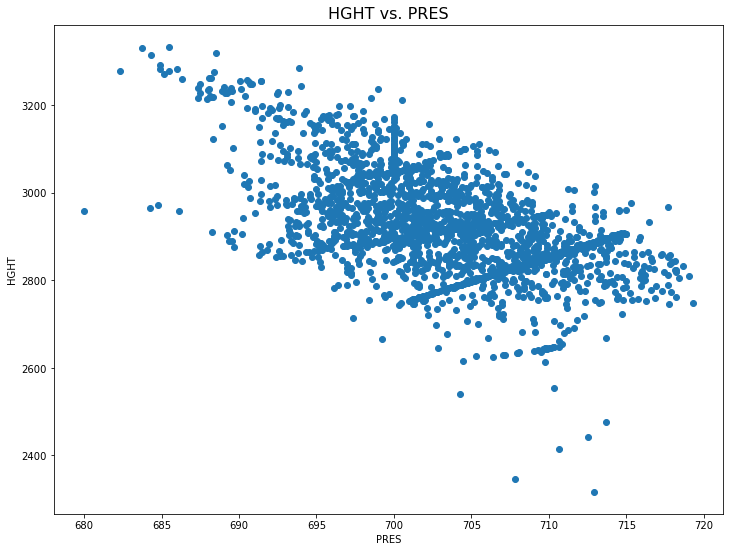

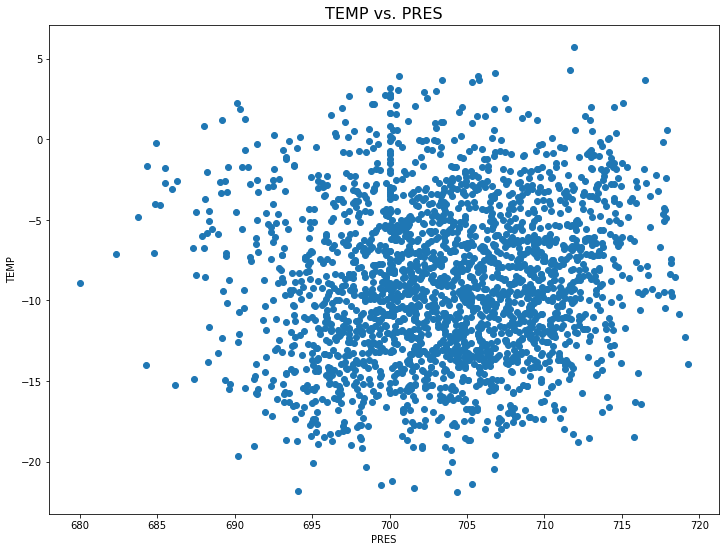

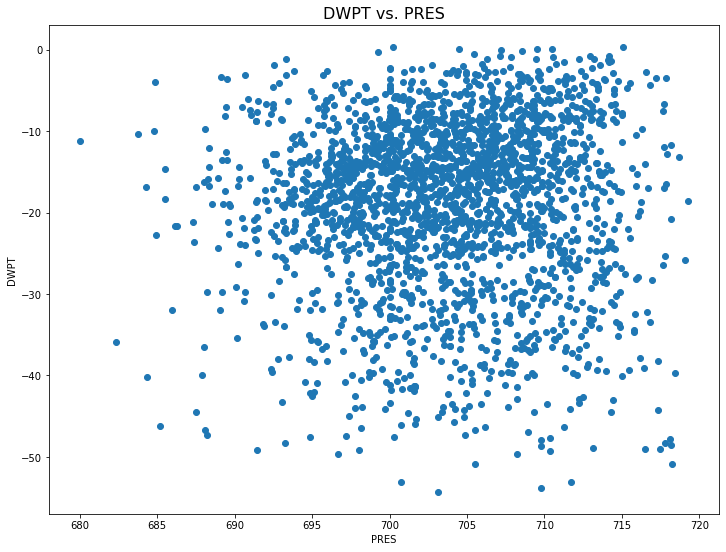

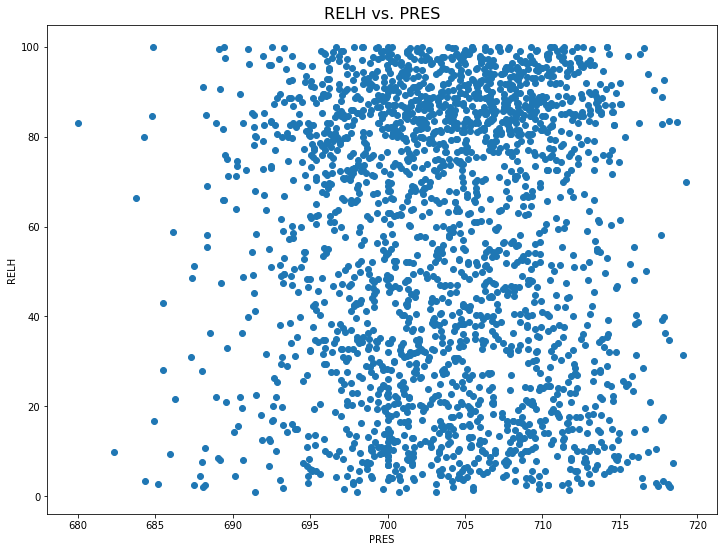

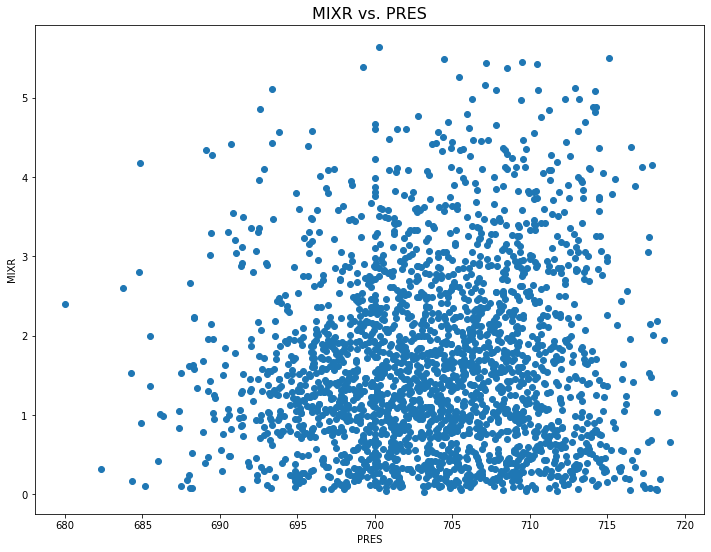

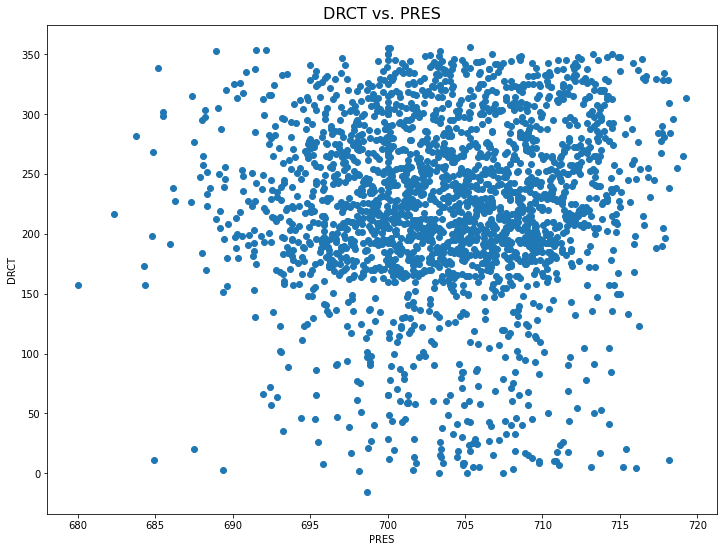

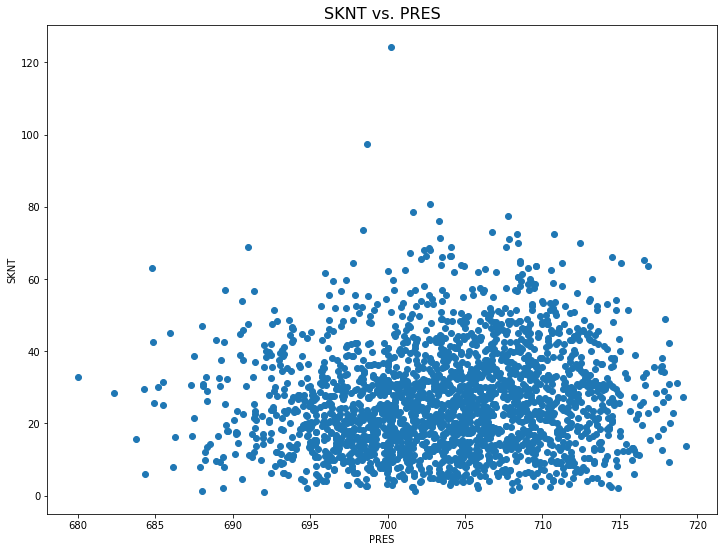

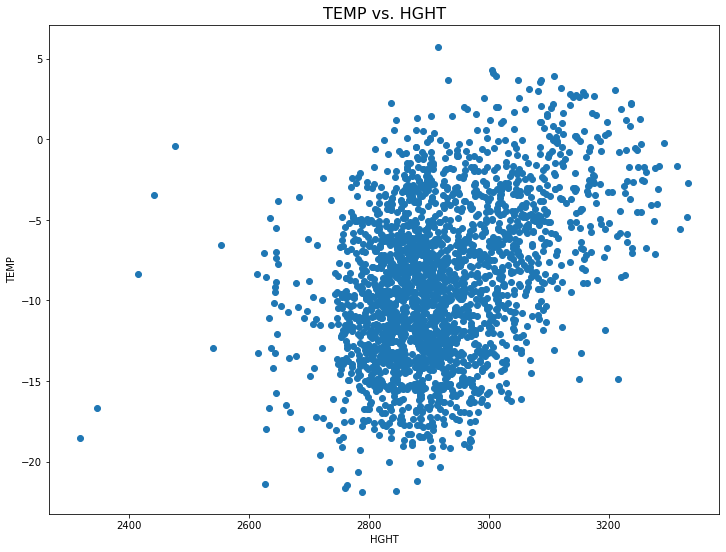

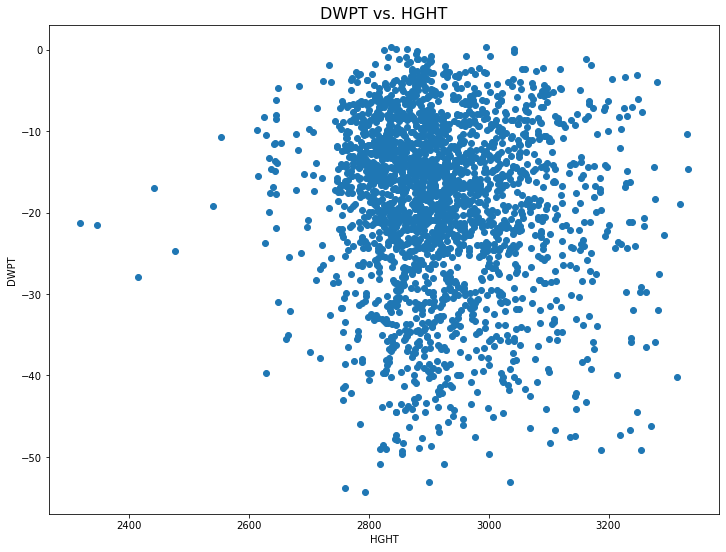

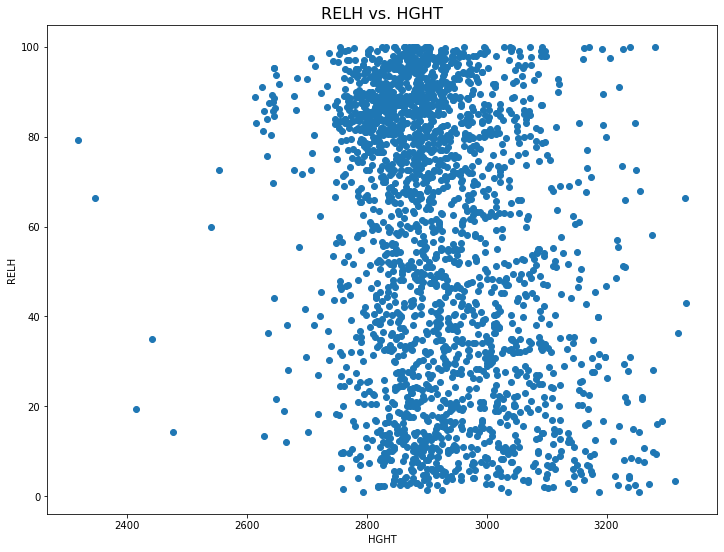

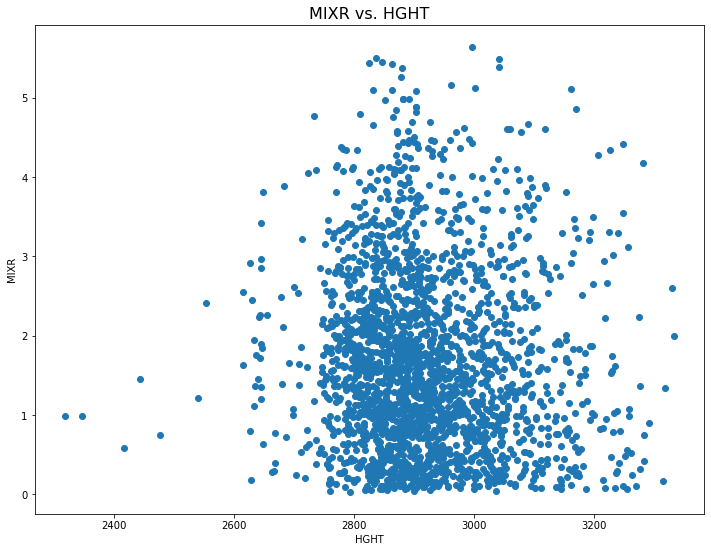

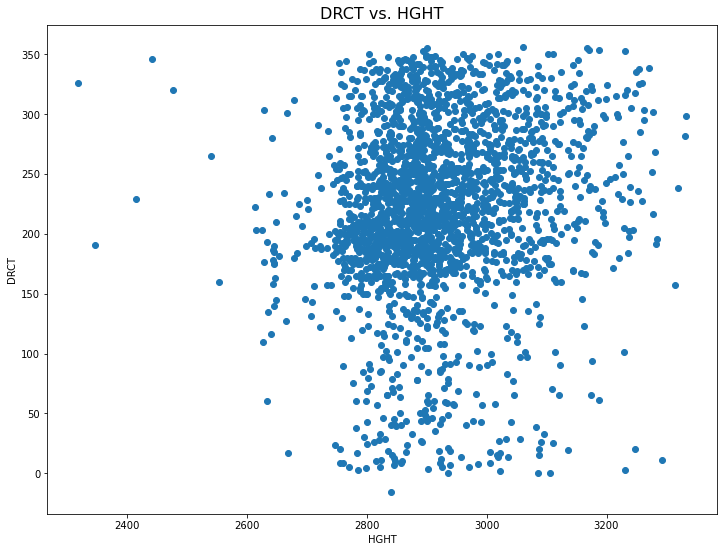

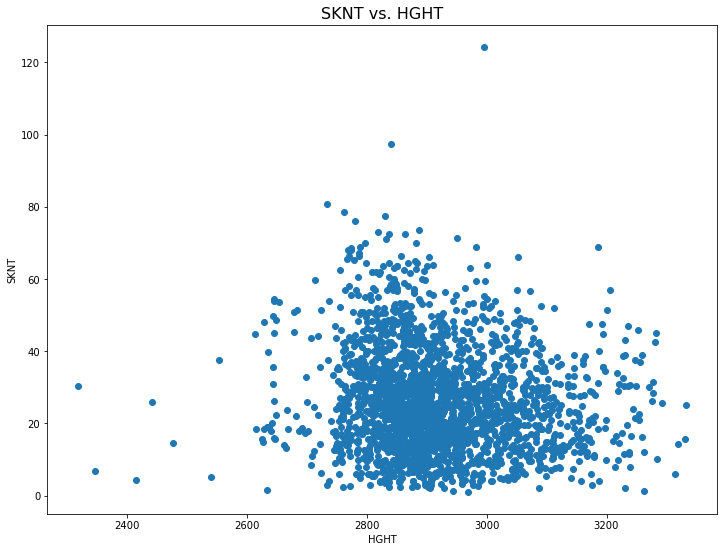

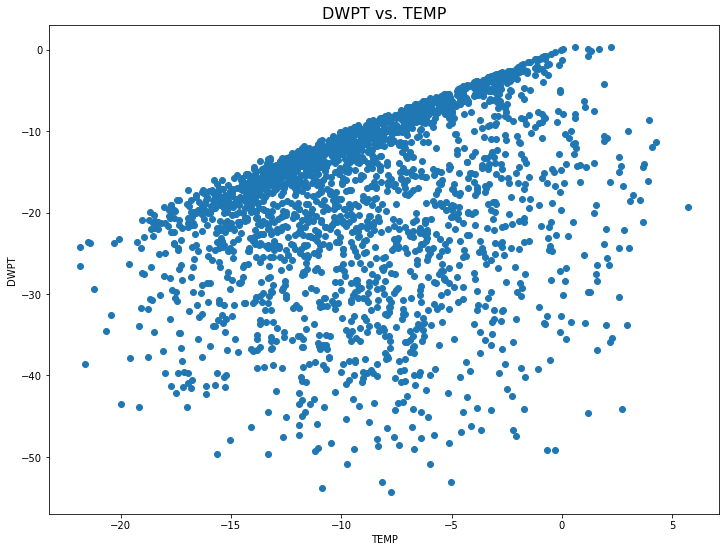

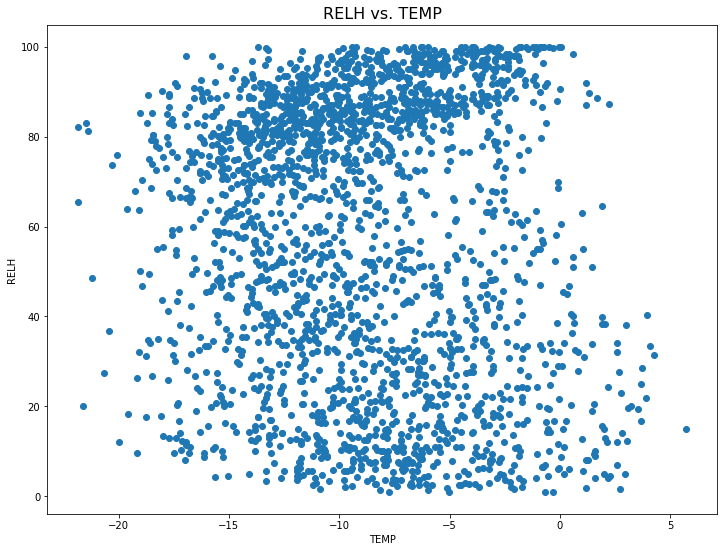

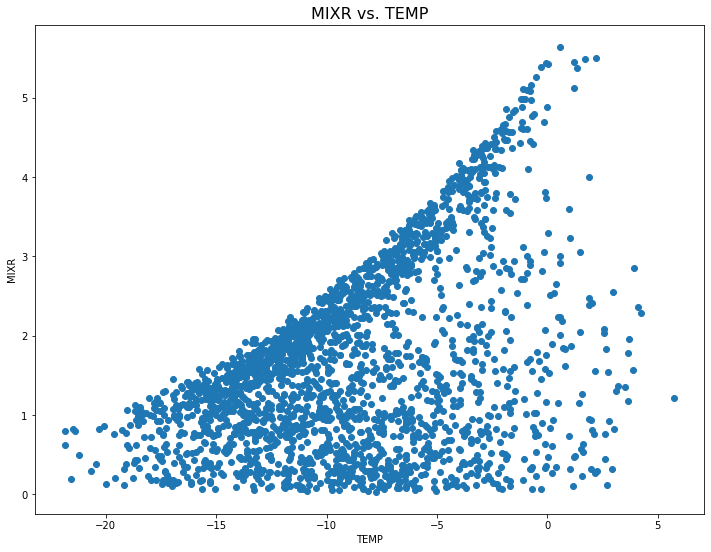

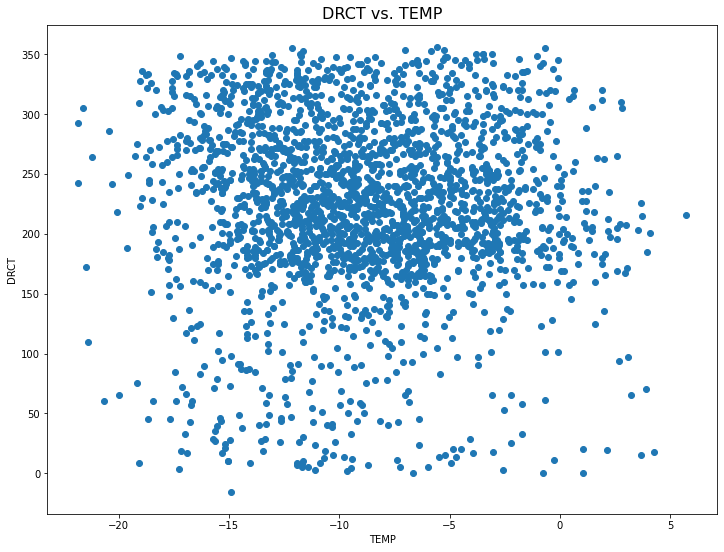

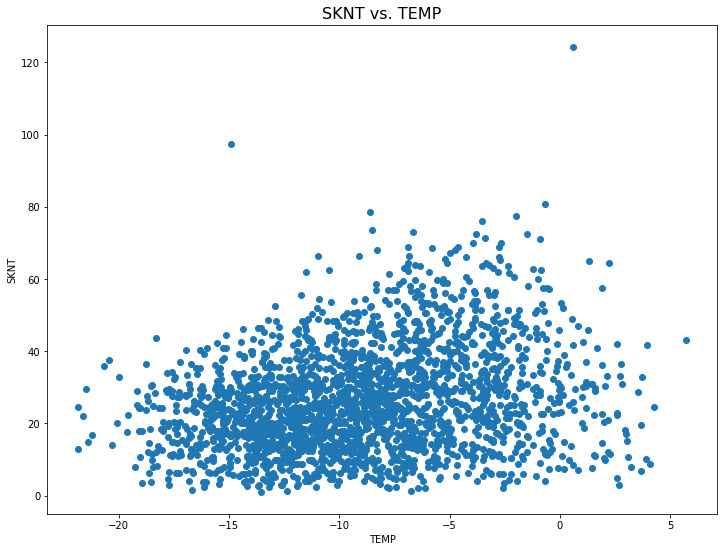

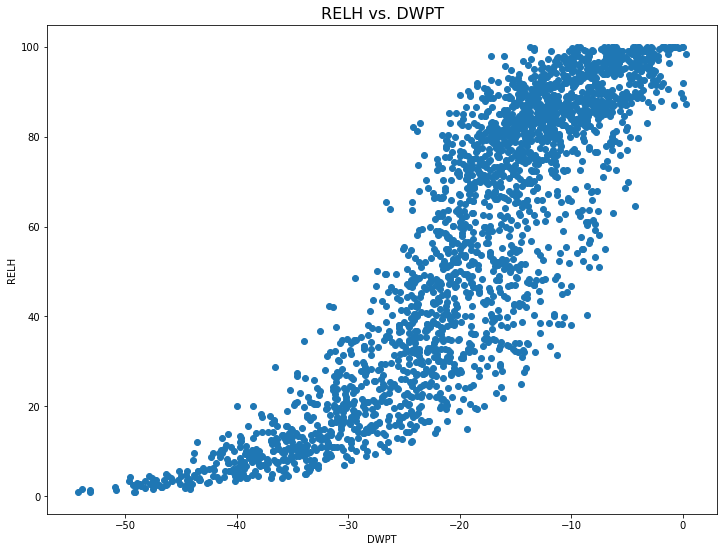

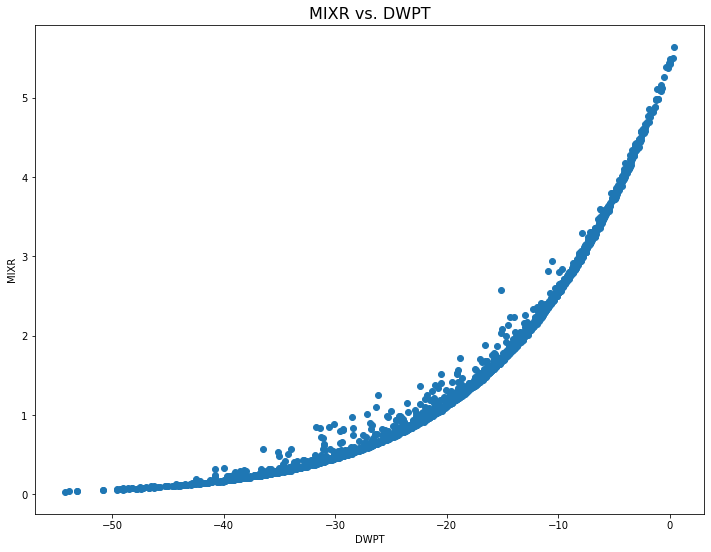

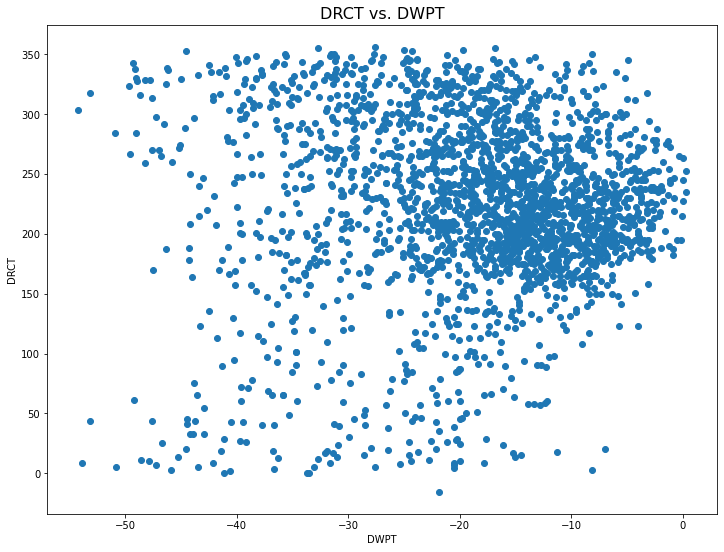

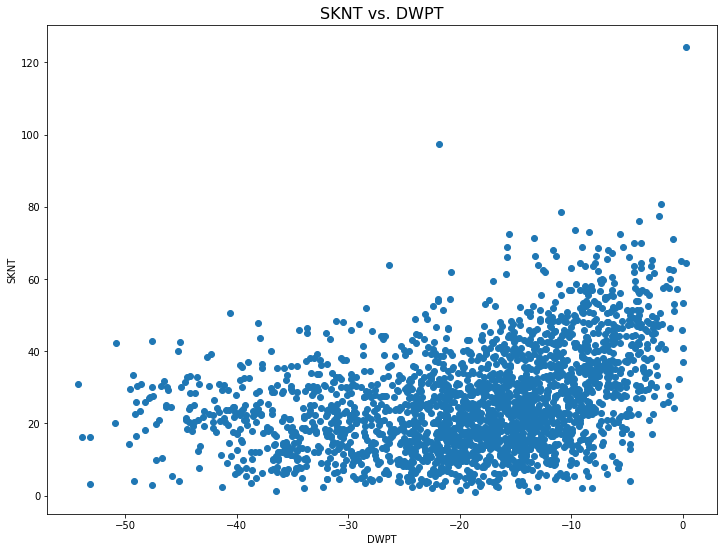

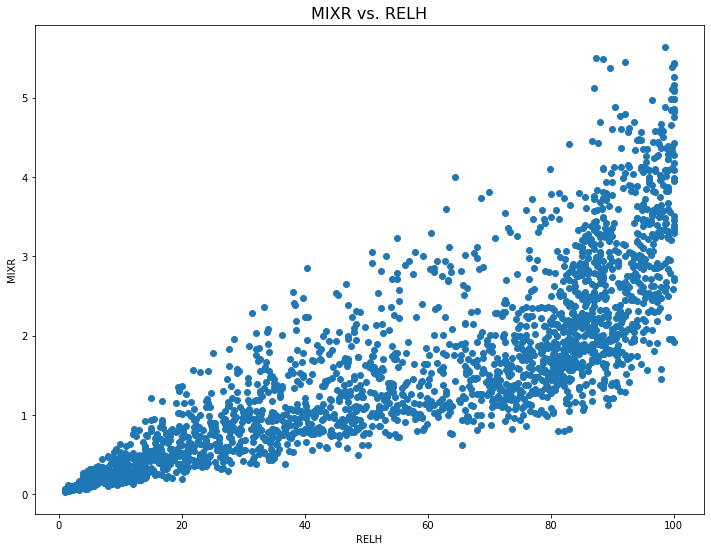

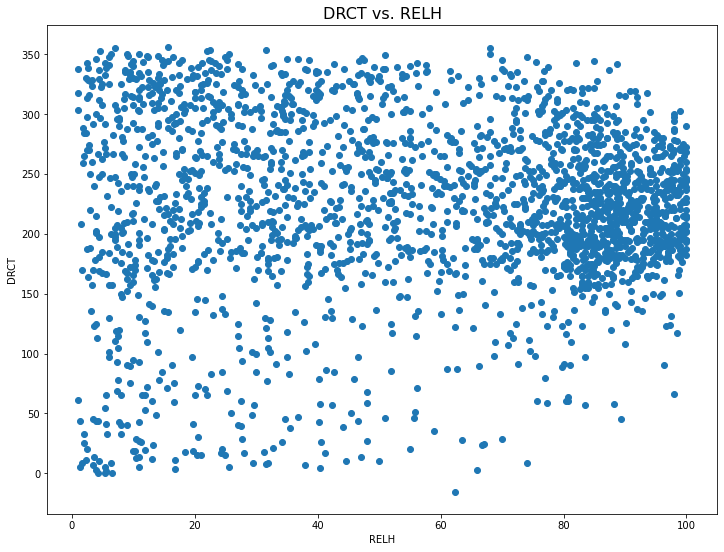

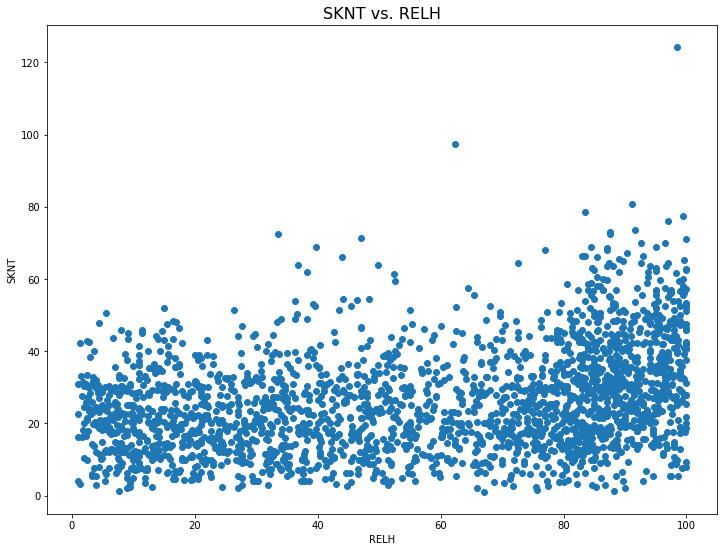

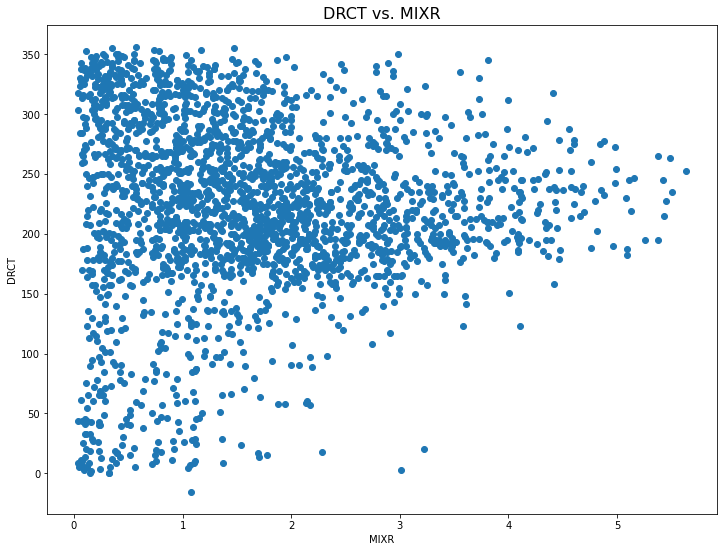

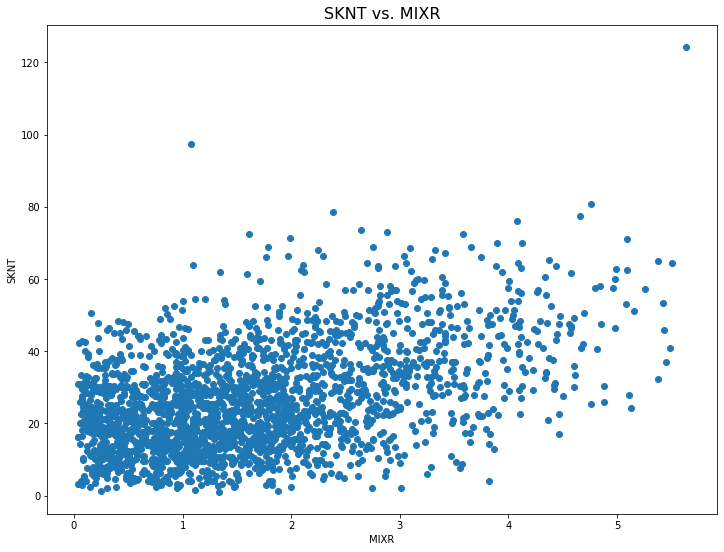

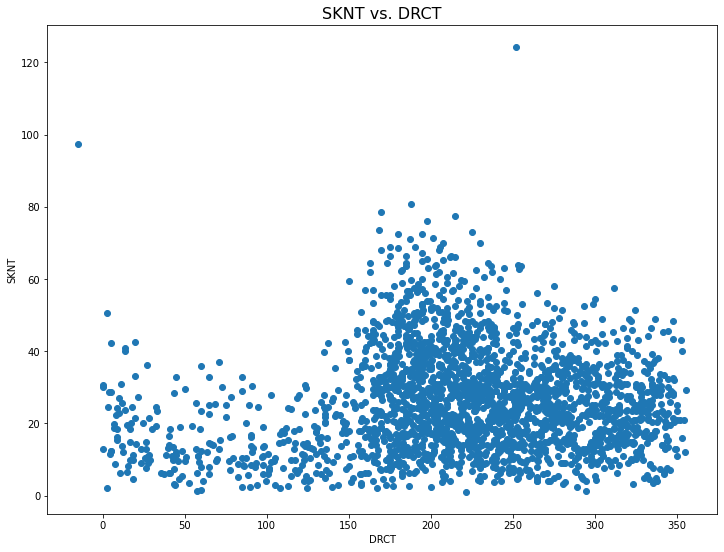

In [89]:
# get two list of columns
columns_x = list(ph_df5.columns)
columns_y = list(ph_df5.columns)

# lose the first element of the y columns so we don't plot first element against first element
columns_y.pop(0)

# loop through x columns
for x_col in columns_x:
    
    # loop through y columns and plot scatter plots
    for y_col in columns_y:
        plt.figure(figsize = (12,9))
        plt.scatter(ph_df5[x_col], ph_df5[y_col])
        plt.title(f"{y_col} vs. {x_col}",
                  size = '16')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.show()
    
    # remove the first element of y-cols so we don't duplicate anything
    columns_y.pop(0)
    
    # prevent error at end
    if len(columns_y) == 0:
        break

From the above scatter plots, we can see that it is going to be very difficult to try and impute values into our series via some sort of regression.  The simple fact is that predicting weather is far outside the scope of this project.  At this point, we are going to drop all remaining rows with NaN values and export a clean csv file.  We will see how the modelling goes and return to this point if needed further down the line.

In [90]:
missing_records_df.shape

(7, 10)

In [91]:
# export to csv - be sure to include index as it is our time!
ph_df5.to_csv('./Data/PortHardyClean.csv')

## Quillayute Station

### Data Exploration

Let's start out with a high level look at our data.

In [92]:
display(q_df.info(),
        q_df.head(),
        q_df.shape,
        q_df.isna().sum().sum() / q_df.shape[0]) # calculate % of rows with NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12207 entries, 0 to 12206
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    12207 non-null  object 
 1   PRES    12207 non-null  float64
 2   HGHT    12207 non-null  int64  
 3   TEMP    12207 non-null  float64
 4   DWPT    12207 non-null  float64
 5   RELH    12207 non-null  int64  
 6   MIXR    12207 non-null  float64
 7   DRCT    12207 non-null  float64
 8   SKNT    12188 non-null  float64
 9   THTA    12188 non-null  float64
 10  THTE    12159 non-null  float64
 11  THTV    12159 non-null  float64
 12  STNM    12207 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 1.2+ MB


None

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0  2014-12-31 16:00:00  703.0  3122  -1.1 -10.1    50  2.54   15.0  19.0   
1  2014-12-31 16:00:00  700.0  3156  -1.3 -10.3    50  2.51   15.0  19.0   
2  2015-01-01 04:00:00  712.0  2985   0.0 -11.0    43  2.33  338.0  12.0   
3  2015-01-01 04:00:00  707.0  3041   0.0 -12.0    40  2.17  335.0  11.0   
4  2015-01-01 04:00:00  706.4  3048  -0.0 -11.8    41  2.21  335.0  11.0   

    THTA   THTE   THTV        STNM  
0  300.9  308.9  301.3  Quillayute  
1  301.0  308.9  301.5  Quillayute  
2  301.0  308.4  301.4  Quillayute  
3  301.6  308.5  302.0  Quillayute  
4  301.6  308.7  302.0  Quillayute

(12207, 13)

0.010977308101908742

From the above it look like we have 12,207 rows across 13 columns.  Several columns have some missing values, but calculated by rows, this accounts for just over 1% of our data.  We will address this shortly.  The data appears to be what is expected based on the first 5 rows.  Data types are all as expected.  Since we might do some manipulation on the `DATE` column, we will change it to a date time.  We will do a quick check to make sure the first and last dates match our known date range first (01 Jan 2015 through 17 Apr 2021).

In [93]:
print(f"First Date: {q_df.iloc[0, :]['DATE']}")
print(f"Last Date: {q_df.iloc[-1, :]['DATE']}")

First Date: 2014-12-31 16:00:00
Last Date: 2021-04-30 04:00:00


From the above it looks like the first date matches our expectations (the night before our first target date).  The ending date is a little past our ending date of 17 Apr 2021.  Let's go ahead and convert the column to datetime and then drop the records that are later than 17 Apr 2021.

In [94]:
# convert column to date time
q_df['DATE'] = pd.to_datetime(q_df['DATE'] )

# confirm it worked
q_df['DATE'].dtypes

dtype('<M8[ns]')

Now that we have the `DATE` column as datetime objects, let's move ahead and drop the records outside our time range

In [95]:
# get the indicies of rows with dates past our last date
past_indicies = q_df[q_df['DATE'] > datetime(2021, 4, 17)].index

# confirm this drop is going to do what we want it to by checking the max date after drop
(q_df.drop(index = past_indicies)['DATE'].max() < datetime(2021, 4, 18))

True

In [96]:
# drop the additional rows
q_df1 = q_df.drop(index = past_indicies).copy()

# confirm
display(q_df1['DATE'].max() < datetime(2021, 4, 18))

# double check
display(q_df1.iloc[-1, :])

True

DATE    2021-04-16 16:00:00
PRES                  691.0
HGHT                   3250
TEMP                    0.8
DWPT                  -27.7
RELH                     10
MIXR                   0.57
DRCT                  130.0
SKNT                   10.0
THTA                  304.4
THTE                  306.4
THTV                  304.6
STNM             Quillayute
Name: 12063, dtype: object

### Data Exploration - Column Shifting

With the data outside of our time range removed let's move onto the rows with missing values.  We know that when we scraped the data from the website that a few records were missing various columns.  The scraping algorithem dealt with this by simply shifting all values to the left most empty columns.  Let's take a look at all of the rows missing data (only 38) to make sure nothing strange is going on.  We will also bring up a few rows of good data for comparison.

In [97]:
display(q_df1[q_df1.isna().any(axis = 1)])
display(q_df1.head())

DATE   PRES  HGHT  TEMP   DWPT  RELH    MIXR   DRCT  \
1602  2015-12-14 16:00:00  724.9  2743  -6.7  345.0    31  292.10  292.1   
1603  2015-12-14 16:00:00  708.0  2927  -6.5  348.0    39  294.30  294.3   
1604  2015-12-14 16:00:00  700.0  3016  -6.9  350.0    43  294.80  294.8   
1605  2015-12-14 16:00:00  697.1  3048  -7.0  350.0    43  295.10  295.1   
1606  2015-12-14 16:00:00  683.0  3207  -7.3  353.0    43  296.40  296.4   
2379  2016-02-28 16:00:00  720.0  2737 -11.5  -12.9    89    1.98  287.4   
2380  2016-02-28 16:00:00  716.0  2780 -11.3  -12.4    92    2.07  288.1   
2381  2016-02-28 16:00:00  700.0  2953 -12.7  -14.4    87    1.80  288.4   
2382  2016-02-28 16:00:00  681.0  3162 -14.3  -16.5    83    1.55  288.9   
3729  2017-01-11 16:00:00  729.0  2572 -10.9  -19.9    47    1.09  287.0   
3730  2017-01-11 16:00:00  723.0  2636 -11.1  -24.1    33    0.76  287.5   
3731  2017-01-11 16:00:00  716.0  2710 -11.9  -23.9    36    0.78  287.4   
3732  2017-01-11 16:00:00  714.0  2732 -11.9  -23.9    36    0.78  287.6   
3733  2017-01-11 16:00:00  709.0  2785 -12.1  -18.1    61    1.30  288.0   
3734  2017-01-11 16:00:00  703.0  2850 -12.3  -17.3    66    1.41  288.5   
3735  2017-01-11 16:00:00  700.0  2883 -12.5  -17.5    66    1.39  288.6   
3736  2017-01-11 16:00:00  693.0  2960 -12.9  -22.9    43    0.88  289.0   
3737  2017-01-11 16:00:00  683.0  3071 -13.7  -19.7    61    1.18  289.3   
3738  2017-01-11 16:00:00  680.0  3104 -13.7  -20.7    56    1.09  289.7   
3739  2017-01-11 16:00:00  675.0  3160 -13.9  -33.9    17    0.32  290.1   
3740  2017-01-11 16:00:00  672.0  3194 -13.9  -39.9     9    0.18  290.4   
4457  2017-03-19 04:00:00  721.9  2743 -14.3  260.0    17  284.10  284.1   
4458  2017-03-19 04:00:00  700.0  2976 -16.1  260.0    19  284.60  284.6   
4459  2017-03-19 04:00:00  693.3  3048 -16.8  260.0    18  284.70  284.7   
4460  2017-03-19 04:00:00  688.0  3106 -17.3  260.0    20  284.70  284.7   
4461  2017-03-19 04:00:00  679.0  3205 -14.9  261.0    22  288.40  288.4   
5052  2017-11-19 16:00:00  727.0  2601  -2.5   -2.8    98    4.30  296.5   
8054  2019-03-26 16:00:00  716.0  2821  -9.9  -31.9    15    0.37  289.6   
8055  2019-03-26 16:00:00  710.0  2886 -10.5  -22.5    37    0.89  289.6   
8056  2019-03-26 16:00:00  706.0  2929 -10.9  -21.9    40    0.94  289.7   
8057  2019-03-26 16:00:00  689.0  3116 -12.3  -34.3    14    0.31  290.1   
8058  2019-03-26 16:00:00  687.0  3138 -12.5  -31.5    19    0.40  290.2   
8059  2019-03-26 16:00:00  683.0  3183 -12.9  -20.9    51    1.06  290.2   
8060  2019-03-26 16:00:00  680.0  3216 -13.1  -18.1    66    1.36  290.3   
8061  2019-03-26 16:00:00  672.0  3306 -13.9  -18.0    71    1.39  290.4   
8264  2019-04-17 04:00:00  727.1  2743  -1.7  275.0    29  297.40  297.4   
8265  2019-04-17 04:00:00  726.0  2755  -1.7  275.0    29  297.50  297.5   
8266  2019-04-17 04:00:00  713.0  2898  -2.7  278.0    33  297.90  297.9   
8267  2019-04-17 04:00:00  700.0  3044  -3.3  280.0    36  298.80  298.8   
8268  2019-04-17 04:00:00  695.0  3101  -3.7  280.0    37  299.00  299.0   
8269  2019-04-17 04:00:00  682.0  3249  -3.7  280.0    39  300.60  300.6   
8270  2019-04-17 04:00:00  673.0  3354  -3.9  280.0    41  301.50  301.5   
9485  2020-02-16 04:00:00  729.0  2661 -10.9  -22.9    37    0.84  287.0   
9486  2020-02-16 04:00:00  720.0  2756 -11.7  -21.7    43    0.94  287.2   
9487  2020-02-16 04:00:00  700.0  2971 -13.1  -25.1    36    0.72  287.9   
9488  2020-02-16 04:00:00  675.0  3247 -15.1  -26.1    39    0.68  288.7   
10714 2020-12-21 04:00:00  720.1  2743  -1.5  230.0    63  298.40  298.4   
10715 2020-12-21 04:00:00  700.0  2968  -2.9  230.0    63  299.20  299.2   

        SKNT   THTA  THTE  THTV        STNM  
1602     NaN    NaN   NaN   NaN  Quillayute  
1603     NaN    NaN   NaN   NaN  Quillayute  
1604     NaN    NaN   NaN   NaN  Quillayute  
1605     NaN    NaN   NaN   NaN  Quillayute  
1606     NaN    NaN   NaN   NaN  Quillayute  
2379   293.4  287.7 

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0 2014-12-31 16:00:00  703.0  3122  -1.1 -10.1    50  2.54   15.0  19.0   
1 2014-12-31 16:00:00  700.0  3156  -1.3 -10.3    50  2.51   15.0  19.0   
2 2015-01-01 04:00:00  712.0  2985   0.0 -11.0    43  2.33  338.0  12.0   
3 2015-01-01 04:00:00  707.0  3041   0.0 -12.0    40  2.17  335.0  11.0   
4 2015-01-01 04:00:00  706.4  3048  -0.0 -11.8    41  2.21  335.0  11.0   

    THTA   THTE   THTV        STNM  
0  300.9  308.9  301.3  Quillayute  
1  301.0  308.9  301.5  Quillayute  
2  301.0  308.4  301.4  Quillayute  
3  301.6  308.5  302.0  Quillayute  
4  301.6  308.7  302.0  Quillayute

In [98]:
# get nan records
nans_df = q_df1[q_df1.isna().any(axis = 1)]

# confirm it worked
nans_df

DATE   PRES  HGHT  TEMP   DWPT  RELH    MIXR   DRCT  \
1602  2015-12-14 16:00:00  724.9  2743  -6.7  345.0    31  292.10  292.1   
1603  2015-12-14 16:00:00  708.0  2927  -6.5  348.0    39  294.30  294.3   
1604  2015-12-14 16:00:00  700.0  3016  -6.9  350.0    43  294.80  294.8   
1605  2015-12-14 16:00:00  697.1  3048  -7.0  350.0    43  295.10  295.1   
1606  2015-12-14 16:00:00  683.0  3207  -7.3  353.0    43  296.40  296.4   
2379  2016-02-28 16:00:00  720.0  2737 -11.5  -12.9    89    1.98  287.4   
2380  2016-02-28 16:00:00  716.0  2780 -11.3  -12.4    92    2.07  288.1   
2381  2016-02-28 16:00:00  700.0  2953 -12.7  -14.4    87    1.80  288.4   
2382  2016-02-28 16:00:00  681.0  3162 -14.3  -16.5    83    1.55  288.9   
3729  2017-01-11 16:00:00  729.0  2572 -10.9  -19.9    47    1.09  287.0   
3730  2017-01-11 16:00:00  723.0  2636 -11.1  -24.1    33    0.76  287.5   
3731  2017-01-11 16:00:00  716.0  2710 -11.9  -23.9    36    0.78  287.4   
3732  2017-01-11 16:00:00  714.0  2732 -11.9  -23.9    36    0.78  287.6   
3733  2017-01-11 16:00:00  709.0  2785 -12.1  -18.1    61    1.30  288.0   
3734  2017-01-11 16:00:00  703.0  2850 -12.3  -17.3    66    1.41  288.5   
3735  2017-01-11 16:00:00  700.0  2883 -12.5  -17.5    66    1.39  288.6   
3736  2017-01-11 16:00:00  693.0  2960 -12.9  -22.9    43    0.88  289.0   
3737  2017-01-11 16:00:00  683.0  3071 -13.7  -19.7    61    1.18  289.3   
3738  2017-01-11 16:00:00  680.0  3104 -13.7  -20.7    56    1.09  289.7   
3739  2017-01-11 16:00:00  675.0  3160 -13.9  -33.9    17    0.32  290.1   
3740  2017-01-11 16:00:00  672.0  3194 -13.9  -39.9     9    0.18  290.4   
4457  2017-03-19 04:00:00  721.9  2743 -14.3  260.0    17  284.10  284.1   
4458  2017-03-19 04:00:00  700.0  2976 -16.1  260.0    19  284.60  284.6   
4459  2017-03-19 04:00:00  693.3  3048 -16.8  260.0    18  284.70  284.7   
4460  2017-03-19 04:00:00  688.0  3106 -17.3  260.0    20  284.70  284.7   
4461  2017-03-19 04:00:00  679.0  3205 -14.9  261.0    22  288.40  288.4   
5052  2017-11-19 16:00:00  727.0  2601  -2.5   -2.8    98    4.30  296.5   
8054  2019-03-26 16:00:00  716.0  2821  -9.9  -31.9    15    0.37  289.6   
8055  2019-03-26 16:00:00  710.0  2886 -10.5  -22.5    37    0.89  289.6   
8056  2019-03-26 16:00:00  706.0  2929 -10.9  -21.9    40    0.94  289.7   
8057  2019-03-26 16:00:00  689.0  3116 -12.3  -34.3    14    0.31  290.1   
8058  2019-03-26 16:00:00  687.0  3138 -12.5  -31.5    19    0.40  290.2   
8059  2019-03-26 16:00:00  683.0  3183 -12.9  -20.9    51    1.06  290.2   
8060  2019-03-26 16:00:00  680.0  3216 -13.1  -18.1    66    1.36  290.3   
8061  2019-03-26 16:00:00  672.0  3306 -13.9  -18.0    71    1.39  290.4   
8264  2019-04-17 04:00:00  727.1  2743  -1.7  275.0    29  297.40  297.4   
8265  2019-04-17 04:00:00  726.0  2755  -1.7  275.0    29  297.50  297.5   
8266  2019-04-17 04:00:00  713.0  2898  -2.7  278.0    33  297.90  297.9   
8267  2019-04-17 04:00:00  700.0  3044  -3.3  280.0    36  298.80  298.8   
8268  2019-04-17 04:00:00  695.0  3101  -3.7  280.0    37  299.00  299.0   
8269  2019-04-17 04:00:00  682.0  3249  -3.7  280.0    39  300.60  300.6   
8270  2019-04-17 04:00:00  673.0  3354  -3.9  280.0    41  301.50  301.5   
9485  2020-02-16 04:00:00  729.0  2661 -10.9  -22.9    37    0.84  287.0   
9486  2020-02-16 04:00:00  720.0  2756 -11.7  -21.7    43    0.94  287.2   
9487  2020-02-16 04:00:00  700.0  2971 -13.1  -25.1    36    0.72  287.9   
9488  2020-02-16 04:00:00  675.0  3247 -15.1  -26.1    39    0.68  288.7   
10714 2020-12-21 04:00:00  720.1  2743  -1.5  230.0    63  298.40  298.4   
10715 2020-12-21 04:00:00  700.0  2968  -2.9  230.0    63  299.20  299.2   

        SKNT   THTA  THTE  THTV        STNM  
1602     NaN    NaN   NaN   NaN  Quillayute  
1603     NaN    NaN   NaN   NaN  Quillayute  
1604     NaN    NaN   NaN   NaN  Quillayute  
1605     NaN    NaN   NaN   NaN  Quillayute  
1606     NaN    NaN   NaN   NaN  Quillayute  
2379   293.4  287.7 

In [100]:
# get a list of flights to work on
incomplete_flights = list(nans_df['DATE'].unique())

With the setup complete, we will now iterate manually through the list of incomplete flight data and shift the records and/or impute manually as needed.  Before we get started, let's get some descriptive statistics on each of the columns from the clean data only as a reference.

In [101]:
q_df1[q_df1.isna().any(axis =1) == False].describe().T

count         mean         std      min      25%     50%      75%  \
PRES  12016.0   702.251282   16.176119   670.00   692.00   700.0   716.00   
HGHT  12016.0  2967.977613  199.259609  2438.00  2772.00  2970.0  3097.00   
TEMP  12016.0    -7.806292    5.035602   -22.10   -11.50    -7.9    -4.30   
DWPT  12016.0   -19.238474   11.191537   -59.10   -25.70   -17.4   -10.90   
RELH  12016.0    52.403379   31.497471     1.00    24.00    52.0    83.00   
MIXR  12016.0     1.649209    1.216160     0.02     0.67     1.4     2.39   
DRCT  12016.0   234.229777   72.794227     0.00   205.00   244.0   281.00   
SKNT  12016.0    25.653961   13.008218     0.00    16.00    24.0    34.00   
THTA  12016.0   293.562675    5.528797   279.90   289.30   293.4   297.50   
THTE  12016.0   298.704594    7.708230   281.70   292.90   297.9   303.90   
THTV  12016.0   293.857265    5.615879   280.10   289.50   293.7   297.80   

          max  
PRES   730.00  
HGHT  3540.00  
TEMP     7.90  
DWPT     3.90  
RELH   100.00  
MIXR     7.01  
DRCT   360.00  
SKNT    75.00  
THTA   311.30  
THTE   325.00  
THTV   311.50

In [102]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR   DRCT  SKNT  \
1602 2015-12-14 16:00:00  724.9  2743  -6.7  345.0    31  292.1  292.1   NaN   
1603 2015-12-14 16:00:00  708.0  2927  -6.5  348.0    39  294.3  294.3   NaN   
1604 2015-12-14 16:00:00  700.0  3016  -6.9  350.0    43  294.8  294.8   NaN   
1605 2015-12-14 16:00:00  697.1  3048  -7.0  350.0    43  295.1  295.1   NaN   
1606 2015-12-14 16:00:00  683.0  3207  -7.3  353.0    43  296.4  296.4   NaN   

      THTA  THTE  THTV        STNM  
1602   NaN   NaN   NaN  Quillayute  
1603   NaN   NaN   NaN  Quillayute  
1604   NaN   NaN   NaN  Quillayute  
1605   NaN   NaN   NaN  Quillayute  
1606   NaN   NaN   NaN  Quillayute

From the above, and comparing it to the statistics of the known clean data, it looks like everything from `DWPT` onwards has been shifted 3 columns to the left.  Let's correct this.

In [103]:
# get indicies of rows we need to change
indicies = q_df1[q_df1['DATE'] == incomplete_flights[0]].index

# loop through indicies
for row in indicies:
   
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, q_df1)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, q_df1)
    
# check it worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
1602 2015-12-14 16:00:00  724.9  2743  -6.7   NaN   NaN  292.1  345.0  31.0   
1603 2015-12-14 16:00:00  708.0  2927  -6.5   NaN   NaN  294.3  348.0  39.0   
1604 2015-12-14 16:00:00  700.0  3016  -6.9   NaN   NaN  294.8  350.0  43.0   
1605 2015-12-14 16:00:00  697.1  3048  -7.0   NaN   NaN  295.1  350.0  43.0   
1606 2015-12-14 16:00:00  683.0  3207  -7.3   NaN   NaN  296.4  353.0  43.0   

      THTA  THTE  THTV        STNM  
1602   NaN   NaN   NaN  Quillayute  
1603   NaN   NaN   NaN  Quillayute  
1604   NaN   NaN   NaN  Quillayute  
1605   NaN   NaN   NaN  Quillayute  
1606   NaN   NaN   NaN  Quillayute

That has solved our issues for `DRTC` and `SKNT`, but has left us with missing info on `DWPT` and `RELH` as well as an incorrect value in `MIXR`.  Let's re-serach the original flight data on the University of Wyoming website to see if we can impute this data.

After a quick search, it looks like this flight lost the dewpoint, relative humidity, and mix ratio measurements early in the flight.  Our next method for imputing is going to involve using the good data we have.  We are going to search for and try to find as many records as possible that match for height and temperature, and then average the records for our remaining three missing columns.  Thos values will be imputed.  Because we intend to average each flight into a single record at the end, this method will allow us to still do that.

In [104]:
# get averages of each numeric column
averages = nans_df[nans_df['DATE'] == incomplete_flights[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = q_df1[(q_df1['HGHT'] > averages['HGHT']*low_rng)
                         & (q_df1['HGHT'] < averages['HGHT']*high_rng)
                         & (q_df1['TEMP'] < averages['TEMP']*low_rng)
                         & (q_df1['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3421/1925146928.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/tmp/ipykernel_3421/1925146928.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



(236, 13)

So the above gives us 236 records to build an average from.  That seems pretty reasonable, so let's move ahead and do that.

In [105]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(nans_df[nans_df['DATE'] == incomplete_flights[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    q_df1.loc[i, 'DWPT'] = averages['DWPT']
    q_df1.loc[i, 'RELH'] = averages['RELH']
    q_df1.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

/tmp/ipykernel_3421/2140620493.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/tmp/ipykernel_3421/2140620493.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



DATE   PRES  HGHT  TEMP       DWPT       RELH      MIXR  \
1602 2015-12-14 16:00:00  724.9  2743  -6.7 -18.112821  54.350427  4.259958   
1603 2015-12-14 16:00:00  708.0  2927  -6.5 -18.112821  54.350427  4.259958   
1604 2015-12-14 16:00:00  700.0  3016  -6.9 -18.112821  54.350427  4.259958   
1605 2015-12-14 16:00:00  697.1  3048  -7.0 -18.112821  54.350427  4.259958   
1606 2015-12-14 16:00:00  683.0  3207  -7.3 -18.112821  54.350427  4.259958   

       DRCT  SKNT  THTA  THTE  THTV        STNM  
1602  345.0  31.0   NaN   NaN   NaN  Quillayute  
1603  348.0  39.0   NaN   NaN   NaN  Quillayute  
1604  350.0  43.0   NaN   NaN   NaN  Quillayute  
1605  350.0  43.0   NaN   NaN   NaN  Quillayute  
1606  353.0  43.0   NaN   NaN   NaN  Quillayute

Comparing the values we have imputed to the known good values, `DWPT` and `RELH` fall very close to the mean/median values of the entire data set.  `MIXR` in above the 3rd quartile, but definitely within the range of the maximum value.  This says to us that our method of selecting a subset of data to impute on is working.

Let's move onto.  The last thing to do is to remove the flight date we have been working on from our list of flights in investigate, and then move onto the next flight.

In [106]:
# remove the first element from our incomplete flights list to track what is next
incomplete_flights.pop(0)

numpy.datetime64('2015-12-14T16:00:00.000000000')

In [107]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
2379 2016-02-28 16:00:00  720.0  2737 -11.5 -12.9  89.0  1.98  287.4  293.4   
2380 2016-02-28 16:00:00  716.0  2780 -11.3 -12.4  92.0  2.07  288.1  294.4   
2381 2016-02-28 16:00:00  700.0  2953 -12.7 -14.4  87.0  1.80  288.4  293.9   
2382 2016-02-28 16:00:00  681.0  3162 -14.3 -16.5  83.0  1.55  288.9  293.7   

       THTA  THTE  THTV        STNM  
2379  287.7   NaN   NaN  Quillayute  
2380  288.4   NaN   NaN  Quillayute  
2381  288.7   NaN   NaN  Quillayute  
2382  289.1   NaN   NaN  Quillayute

For this flight it looks like we are either missing `SKNT` or both `DRCT` and `SKNT`.  Let's take a look a the original flight data.

As suspected, we are missing both `DRCT` and `SKNT` for the entire flight.  Theses are much harder to impute and will require further EDA to possibly come up with values.  We are going to put `NaN` values into wind direction and speed so we can pull these out later.

In [108]:
# get indicies of rows we need to change
indicies = q_df1[q_df1['DATE'] == incomplete_flights[0]].index

# loop through and set `DRCT` and `SKNT` to NaN so we can pull them out later
for i in indicies:
    q_df1.loc[i, 'DRCT'] = np.NaN
    q_df1.loc[i, 'SKNT'] = np.NaN

# confirm it worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
2379 2016-02-28 16:00:00  720.0  2737 -11.5 -12.9  89.0  1.98   NaN   NaN   
2380 2016-02-28 16:00:00  716.0  2780 -11.3 -12.4  92.0  2.07   NaN   NaN   
2381 2016-02-28 16:00:00  700.0  2953 -12.7 -14.4  87.0  1.80   NaN   NaN   
2382 2016-02-28 16:00:00  681.0  3162 -14.3 -16.5  83.0  1.55   NaN   NaN   

       THTA  THTE  THTV        STNM  
2379  287.7   NaN   NaN  Quillayute  
2380  288.4   NaN   NaN  Quillayute  
2381  288.7   NaN   NaN  Quillayute  
2382  289.1   NaN   NaN  Quillayute

In [109]:
# remove the first element from our incomplete flights list to track what is next
incomplete_flights.pop(0)

numpy.datetime64('2016-02-28T16:00:00.000000000')

In [110]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
3729 2017-01-11 16:00:00  729.0  2572 -10.9 -19.9  47.0  1.09  287.0  290.4   
3730 2017-01-11 16:00:00  723.0  2636 -11.1 -24.1  33.0  0.76  287.5  289.9   
3731 2017-01-11 16:00:00  716.0  2710 -11.9 -23.9  36.0  0.78  287.4  289.9   
3732 2017-01-11 16:00:00  714.0  2732 -11.9 -23.9  36.0  0.78  287.6  290.1   
3733 2017-01-11 16:00:00  709.0  2785 -12.1 -18.1  61.0  1.30  288.0  292.1   
3734 2017-01-11 16:00:00  703.0  2850 -12.3 -17.3  66.0  1.41  288.5  292.9   
3735 2017-01-11 16:00:00  700.0  2883 -12.5 -17.5  66.0  1.39  288.6  292.9   
3736 2017-01-11 16:00:00  693.0  2960 -12.9 -22.9  43.0  0.88  289.0  291.8   
3737 2017-01-11 16:00:00  683.0  3071 -13.7 -19.7  61.0  1.18  289.3  293.0   
3738 2017-01-11 16:00:00  680.0  3104 -13.7 -20.7  56.0  1.09  289.7  293.1   
3739 2017-01-11 16:00:00  675.0  3160 -13.9 -33.9  17.0  0.32  290.1  291.2   
3740 2017-01-11 16:00:00  672.0  3194 -13.9 -39.9   9.0  0.18  290.4  291.1   

       THTA  THTE  THTV        STNM  
3729  287.2   NaN   NaN  Quillayute  
3730  287.6   NaN   NaN  Quillayute  
3731  287.6   NaN   NaN  Quillayute  
3732  287.8   NaN   NaN  Quillayute  
3733  288.2   NaN   NaN  Quillayute  
3734  288.7   NaN   NaN  Quillayute  
3735  288.9   NaN   NaN  Quillayute  
3736  289.1   NaN   NaN  Quillayute  
3737  289.5   NaN   NaN  Quillayute  
3738  289.9   NaN   NaN  Quillayute  
3739  290.1   NaN   NaN  Quillayute  
3740  290.5   NaN   NaN  Quillayute

Unfortunatley this looks like a similar situation to the case immediately above, but let's check the original flight data to be sure.

As suspected, we are in the same situation missing `DRTC` and `SKNT` for the entire flight.  We will again impute NaN to our two key columns and then skip and move onto the next.

In [111]:
# get indicies of rows we need to change
indicies = q_df1[q_df1['DATE'] == incomplete_flights[0]].index

# loop through and set `DRCT` and `SKNT` to NaN so we can pull them out later
for i in indicies:
    q_df1.loc[i, 'DRCT'] = np.NaN
    q_df1.loc[i, 'SKNT'] = np.NaN

# confirm it worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
3729 2017-01-11 16:00:00  729.0  2572 -10.9 -19.9  47.0  1.09   NaN   NaN   
3730 2017-01-11 16:00:00  723.0  2636 -11.1 -24.1  33.0  0.76   NaN   NaN   
3731 2017-01-11 16:00:00  716.0  2710 -11.9 -23.9  36.0  0.78   NaN   NaN   
3732 2017-01-11 16:00:00  714.0  2732 -11.9 -23.9  36.0  0.78   NaN   NaN   
3733 2017-01-11 16:00:00  709.0  2785 -12.1 -18.1  61.0  1.30   NaN   NaN   
3734 2017-01-11 16:00:00  703.0  2850 -12.3 -17.3  66.0  1.41   NaN   NaN   
3735 2017-01-11 16:00:00  700.0  2883 -12.5 -17.5  66.0  1.39   NaN   NaN   
3736 2017-01-11 16:00:00  693.0  2960 -12.9 -22.9  43.0  0.88   NaN   NaN   
3737 2017-01-11 16:00:00  683.0  3071 -13.7 -19.7  61.0  1.18   NaN   NaN   
3738 2017-01-11 16:00:00  680.0  3104 -13.7 -20.7  56.0  1.09   NaN   NaN   
3739 2017-01-11 16:00:00  675.0  3160 -13.9 -33.9  17.0  0.32   NaN   NaN   
3740 2017-01-11 16:00:00  672.0  3194 -13.9 -39.9   9.0  0.18   NaN   NaN   

       THTA  THTE  THTV        STNM  
3729  287.2   NaN   NaN  Quillayute  
3730  287.6   NaN   NaN  Quillayute  
3731  287.6   NaN   NaN  Quillayute  
3732  287.8   NaN   NaN  Quillayute  
3733  288.2   NaN   NaN  Quillayute  
3734  288.7   NaN   NaN  Quillayute  
3735  288.9   NaN   NaN  Quillayute  
3736  289.1   NaN   NaN  Quillayute  
3737  289.5   NaN   NaN  Quillayute  
3738  289.9   NaN   NaN  Quillayute  
3739  290.1   NaN   NaN  Quillayute  
3740  290.5   NaN   NaN  Quillayute

In [112]:
# remove the first element from our incomplete flights list to track what is next
incomplete_flights.pop(0)

numpy.datetime64('2017-01-11T16:00:00.000000000')

In [113]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR   DRCT  SKNT  \
4457 2017-03-19 04:00:00  721.9  2743 -14.3  260.0  17.0  284.1  284.1   NaN   
4458 2017-03-19 04:00:00  700.0  2976 -16.1  260.0  19.0  284.6  284.6   NaN   
4459 2017-03-19 04:00:00  693.3  3048 -16.8  260.0  18.0  284.7  284.7   NaN   
4460 2017-03-19 04:00:00  688.0  3106 -17.3  260.0  20.0  284.7  284.7   NaN   
4461 2017-03-19 04:00:00  679.0  3205 -14.9  261.0  22.0  288.4  288.4   NaN   

      THTA  THTE  THTV        STNM  
4457   NaN   NaN   NaN  Quillayute  
4458   NaN   NaN   NaN  Quillayute  
4459   NaN   NaN   NaN  Quillayute  
4460   NaN   NaN   NaN  Quillayute  
4461   NaN   NaN   NaN  Quillayute

Here, it looks like the dewpoint through mix ratio were missing and shifted everything else to the left.  That means we can move `DWPT` to `DRCT` and `RELH` to `SKNT`.

In [114]:
# get indicies of rows we need to changec
indicies = q_df1[q_df1['DATE'] == incomplete_flights[0]].index

# loop through indicies
for row in indicies:
   
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, q_df1)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, q_df1)
    
# check it worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
4457 2017-03-19 04:00:00  721.9  2743 -14.3   NaN   NaN  284.1  260.0  17.0   
4458 2017-03-19 04:00:00  700.0  2976 -16.1   NaN   NaN  284.6  260.0  19.0   
4459 2017-03-19 04:00:00  693.3  3048 -16.8   NaN   NaN  284.7  260.0  18.0   
4460 2017-03-19 04:00:00  688.0  3106 -17.3   NaN   NaN  284.7  260.0  20.0   
4461 2017-03-19 04:00:00  679.0  3205 -14.9   NaN   NaN  288.4  261.0  22.0   

      THTA  THTE  THTV        STNM  
4457   NaN   NaN   NaN  Quillayute  
4458   NaN   NaN   NaN  Quillayute  
4459   NaN   NaN   NaN  Quillayute  
4460   NaN   NaN   NaN  Quillayute  
4461   NaN   NaN   NaN  Quillayute

That now leaves us with missing data in dewpoint, relative humidity, and mix ratio.  Let's check the original flight data to see if there is any info.

As expected, all three are missing from the whole flight.  Let's do some averaging and impute these values.

In [115]:
# get averages of each numeric column
averages = nans_df[nans_df['DATE'] == incomplete_flights[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = q_df1[(q_df1['HGHT'] > averages['HGHT']*low_rng)
                         & (q_df1['HGHT'] < averages['HGHT']*high_rng)
                         & (q_df1['TEMP'] < averages['TEMP']*low_rng)
                         & (q_df1['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3421/1925146928.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/tmp/ipykernel_3421/1925146928.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



(294, 13)

So the above gives us 294 records to build an average from.  That seems pretty reasonable, so let's move ahead and do that.

In [116]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(nans_df[nans_df['DATE'] == incomplete_flights[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    q_df1.loc[i, 'DWPT'] = averages['DWPT']
    q_df1.loc[i, 'RELH'] = averages['RELH']
    q_df1.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

/tmp/ipykernel_3421/2140620493.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/tmp/ipykernel_3421/2140620493.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



DATE   PRES  HGHT  TEMP       DWPT       RELH      MIXR  \
4457 2017-03-19 04:00:00  721.9  2743 -14.3 -25.317065  52.232082  1.818027   
4458 2017-03-19 04:00:00  700.0  2976 -16.1 -25.317065  52.232082  1.818027   
4459 2017-03-19 04:00:00  693.3  3048 -16.8 -25.317065  52.232082  1.818027   
4460 2017-03-19 04:00:00  688.0  3106 -17.3 -25.317065  52.232082  1.818027   
4461 2017-03-19 04:00:00  679.0  3205 -14.9 -25.317065  52.232082  1.818027   

       DRCT  SKNT  THTA  THTE  THTV        STNM  
4457  260.0  17.0   NaN   NaN   NaN  Quillayute  
4458  260.0  19.0   NaN   NaN   NaN  Quillayute  
4459  260.0  18.0   NaN   NaN   NaN  Quillayute  
4460  260.0  20.0   NaN   NaN   NaN  Quillayute  
4461  261.0  22.0   NaN   NaN   NaN  Quillayute

It looks like all are imputed values fall reasonably within the ranges of the known good data.  Let's move onto the next record.

In [117]:
# remove the first element from our incomplete flights list to track what is next
incomplete_flights.pop(0)

numpy.datetime64('2017-03-19T04:00:00.000000000')

In [118]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
5052 2017-11-19 16:00:00  727.0  2601  -2.5  -2.8  98.0   4.3  296.5  309.4   

       THTA  THTE  THTV        STNM  
5052  297.2   NaN   NaN  Quillayute

This looks like we might only be missing `SKNT`.  Let's check the original data.

It looks like this flight terminated after this specific record.  The good news is the wind speed was relatively steady and we have a measurement less than 200m below.  The wind direction is also missing, but again, we will take the value from the last measurement.  We are going to manually impute that now.

In [119]:
# get the index of the record to impute
index = list(nans_df[nans_df['DATE'] == incomplete_flights[0]].index)[0]

# impute the records
q_df1.loc[index, 'DRCT'] = 240
q_df1.loc[index, 'SKNT'] = 56

# check it has worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
5052 2017-11-19 16:00:00  727.0  2601  -2.5  -2.8  98.0   4.3  240.0  56.0   

       THTA  THTE  THTV        STNM  
5052  297.2   NaN   NaN  Quillayute

In [120]:
# remove the first element from our incomplete flights list to track what is next
incomplete_flights.pop(0)

numpy.datetime64('2017-11-19T16:00:00.000000000')

In [121]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
8054 2019-03-26 16:00:00  716.0  2821  -9.9 -31.9  15.0  0.37  289.6  290.9   
8055 2019-03-26 16:00:00  710.0  2886 -10.5 -22.5  37.0  0.89  289.6  292.5   
8056 2019-03-26 16:00:00  706.0  2929 -10.9 -21.9  40.0  0.94  289.7  292.7   
8057 2019-03-26 16:00:00  689.0  3116 -12.3 -34.3  14.0  0.31  290.1  291.2   
8058 2019-03-26 16:00:00  687.0  3138 -12.5 -31.5  19.0  0.40  290.2  291.5   
8059 2019-03-26 16:00:00  683.0  3183 -12.9 -20.9  51.0  1.06  290.2  293.6   
8060 2019-03-26 16:00:00  680.0  3216 -13.1 -18.1  66.0  1.36  290.3  294.6   
8061 2019-03-26 16:00:00  672.0  3306 -13.9 -18.0  71.0  1.39  290.4  294.8   

       THTA  THTE  THTV        STNM  
8054  289.7   NaN   NaN  Quillayute  
8055  289.8   NaN   NaN  Quillayute  
8056  289.8   NaN   NaN  Quillayute  
8057  290.2   NaN   NaN  Quillayute  
8058  290.2   NaN   NaN  Quillayute  
8059  290.4   NaN   NaN  Quillayute  
8060  290.6   NaN   NaN  Quillayute  
8061  290.7   NaN   NaN  Quillayute

Unfortunatley this flight looks like it might be missing both wind direction and speed.  Let's check the original flight data.

The original flight data is missing both `DRCT` and `SKNT` for enough of the flight that we cannot impute anything.  We will impute NaN's and set this aside to try and deal with later.

In [122]:
# get indicies of rows we need to change
indicies = q_df1[q_df1['DATE'] == incomplete_flights[0]].index

# loop through and set `DRCT` and `SKNT` to NaN so we can pull them out later
for i in indicies:
    q_df1.loc[i, 'DRCT'] = np.NaN
    q_df1.loc[i, 'SKNT'] = np.NaN

# confirm it worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
8054 2019-03-26 16:00:00  716.0  2821  -9.9 -31.9  15.0  0.37   NaN   NaN   
8055 2019-03-26 16:00:00  710.0  2886 -10.5 -22.5  37.0  0.89   NaN   NaN   
8056 2019-03-26 16:00:00  706.0  2929 -10.9 -21.9  40.0  0.94   NaN   NaN   
8057 2019-03-26 16:00:00  689.0  3116 -12.3 -34.3  14.0  0.31   NaN   NaN   
8058 2019-03-26 16:00:00  687.0  3138 -12.5 -31.5  19.0  0.40   NaN   NaN   
8059 2019-03-26 16:00:00  683.0  3183 -12.9 -20.9  51.0  1.06   NaN   NaN   
8060 2019-03-26 16:00:00  680.0  3216 -13.1 -18.1  66.0  1.36   NaN   NaN   
8061 2019-03-26 16:00:00  672.0  3306 -13.9 -18.0  71.0  1.39   NaN   NaN   

       THTA  THTE  THTV        STNM  
8054  289.7   NaN   NaN  Quillayute  
8055  289.8   NaN   NaN  Quillayute  
8056  289.8   NaN   NaN  Quillayute  
8057  290.2   NaN   NaN  Quillayute  
8058  290.2   NaN   NaN  Quillayute  
8059  290.4   NaN   NaN  Quillayute  
8060  290.6   NaN   NaN  Quillayute  
8061  290.7   NaN   NaN  Quillayute

In [123]:
# remove the first element from our incomplete flights list to track what is next
incomplete_flights.pop(0)

numpy.datetime64('2019-03-26T16:00:00.000000000')

In [124]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR   DRCT  SKNT  \
8264 2019-04-17 04:00:00  727.1  2743  -1.7  275.0  29.0  297.4  297.4   NaN   
8265 2019-04-17 04:00:00  726.0  2755  -1.7  275.0  29.0  297.5  297.5   NaN   
8266 2019-04-17 04:00:00  713.0  2898  -2.7  278.0  33.0  297.9  297.9   NaN   
8267 2019-04-17 04:00:00  700.0  3044  -3.3  280.0  36.0  298.8  298.8   NaN   
8268 2019-04-17 04:00:00  695.0  3101  -3.7  280.0  37.0  299.0  299.0   NaN   
8269 2019-04-17 04:00:00  682.0  3249  -3.7  280.0  39.0  300.6  300.6   NaN   
8270 2019-04-17 04:00:00  673.0  3354  -3.9  280.0  41.0  301.5  301.5   NaN   

      THTA  THTE  THTV        STNM  
8264   NaN   NaN   NaN  Quillayute  
8265   NaN   NaN   NaN  Quillayute  
8266   NaN   NaN   NaN  Quillayute  
8267   NaN   NaN   NaN  Quillayute  
8268   NaN   NaN   NaN  Quillayute  
8269   NaN   NaN   NaN  Quillayute  
8270   NaN   NaN   NaN  Quillayute

This looks like we are missing dew point, relative humidity, and mix ratio resulting in a left shift.  Let's check with the original data.

As suspected, `DWPT` through `MIXR` are missing.  Let's shift `DWPT` to `DRCT` and `RELH` to `SKNT` and then impute the missing from averages.

In [125]:
# get indicies of rows we need to changec
indicies = q_df1[q_df1['DATE'] == incomplete_flights[0]].index

# loop through indicies
for row in indicies:
   
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, q_df1)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, q_df1)
    
# check it worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
8264 2019-04-17 04:00:00  727.1  2743  -1.7   NaN   NaN  297.4  275.0  29.0   
8265 2019-04-17 04:00:00  726.0  2755  -1.7   NaN   NaN  297.5  275.0  29.0   
8266 2019-04-17 04:00:00  713.0  2898  -2.7   NaN   NaN  297.9  278.0  33.0   
8267 2019-04-17 04:00:00  700.0  3044  -3.3   NaN   NaN  298.8  280.0  36.0   
8268 2019-04-17 04:00:00  695.0  3101  -3.7   NaN   NaN  299.0  280.0  37.0   
8269 2019-04-17 04:00:00  682.0  3249  -3.7   NaN   NaN  300.6  280.0  39.0   
8270 2019-04-17 04:00:00  673.0  3354  -3.9   NaN   NaN  301.5  280.0  41.0   

      THTA  THTE  THTV        STNM  
8264   NaN   NaN   NaN  Quillayute  
8265   NaN   NaN   NaN  Quillayute  
8266   NaN   NaN   NaN  Quillayute  
8267   NaN   NaN   NaN  Quillayute  
8268   NaN   NaN   NaN  Quillayute  
8269   NaN   NaN   NaN  Quillayute  
8270   NaN   NaN   NaN  Quillayute

In [126]:
# get averages of each numeric column
averages = nans_df[nans_df['DATE'] == incomplete_flights[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = q_df1[(q_df1['HGHT'] > averages['HGHT']*low_rng)
                         & (q_df1['HGHT'] < averages['HGHT']*high_rng)
                         & (q_df1['TEMP'] < averages['TEMP']*low_rng)
                         & (q_df1['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3421/1925146928.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/tmp/ipykernel_3421/1925146928.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



(96, 13)

Only 96 records to build an average from.  That will be good enough, so let's move ahead and do that.

In [127]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(nans_df[nans_df['DATE'] == incomplete_flights[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    q_df1.loc[i, 'DWPT'] = averages['DWPT']
    q_df1.loc[i, 'RELH'] = averages['RELH']
    q_df1.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

/tmp/ipykernel_3421/2140620493.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/tmp/ipykernel_3421/2140620493.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



DATE   PRES  HGHT  TEMP       DWPT       RELH      MIXR  \
8264 2019-04-17 04:00:00  727.1  2743  -1.7 -14.171875  51.927083  5.359792   
8265 2019-04-17 04:00:00  726.0  2755  -1.7 -14.171875  51.927083  5.359792   
8266 2019-04-17 04:00:00  713.0  2898  -2.7 -14.171875  51.927083  5.359792   
8267 2019-04-17 04:00:00  700.0  3044  -3.3 -14.171875  51.927083  5.359792   
8268 2019-04-17 04:00:00  695.0  3101  -3.7 -14.171875  51.927083  5.359792   
8269 2019-04-17 04:00:00  682.0  3249  -3.7 -14.171875  51.927083  5.359792   
8270 2019-04-17 04:00:00  673.0  3354  -3.9 -14.171875  51.927083  5.359792   

       DRCT  SKNT  THTA  THTE  THTV        STNM  
8264  275.0  29.0   NaN   NaN   NaN  Quillayute  
8265  275.0  29.0   NaN   NaN   NaN  Quillayute  
8266  278.0  33.0   NaN   NaN   NaN  Quillayute  
8267  280.0  36.0   NaN   NaN   NaN  Quillayute  
8268  280.0  37.0   NaN   NaN   NaN  Quillayute  
8269  280.0  39.0   NaN   NaN   NaN  Quillayute  
8270  280.0  41.0   NaN   NaN   NaN  Quillayute

Again, both dewpoint and relative humidity fall very close to there means.  Mix ratio is again well into the 4th quartile.  We will have to keep an eye on that.  Moving onto the next record.

In [128]:
# remove the first element from our incomplete flights list to track what is next
incomplete_flights.pop(0)

numpy.datetime64('2019-04-17T04:00:00.000000000')

In [129]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT   SKNT  \
9485 2020-02-16 04:00:00  729.0  2661 -10.9 -22.9  37.0  0.84  287.0  289.7   
9486 2020-02-16 04:00:00  720.0  2756 -11.7 -21.7  43.0  0.94  287.2  290.2   
9487 2020-02-16 04:00:00  700.0  2971 -13.1 -25.1  36.0  0.72  287.9  290.3   
9488 2020-02-16 04:00:00  675.0  3247 -15.1 -26.1  39.0  0.68  288.7  290.9   

       THTA  THTE  THTV        STNM  
9485  287.2   NaN   NaN  Quillayute  
9486  287.3   NaN   NaN  Quillayute  
9487  288.1   NaN   NaN  Quillayute  
9488  288.8   NaN   NaN  Quillayute

Here it appears we are missing wind direction and speed.  Let's check the original data to confirm.

Unfortunatley are intuition was correct.  We will impute NaN's and set these records aside to deal with them later.  Onto the last flight!

In [130]:
# get indicies of rows we need to change
indicies = q_df1[q_df1['DATE'] == incomplete_flights[0]].index

# loop through and set `DRCT` and `SKNT` to NaN so we can pull them out later
for i in indicies:
    q_df1.loc[i, 'DRCT'] = np.NaN
    q_df1.loc[i, 'SKNT'] = np.NaN

# confirm it worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
9485 2020-02-16 04:00:00  729.0  2661 -10.9 -22.9  37.0  0.84   NaN   NaN   
9486 2020-02-16 04:00:00  720.0  2756 -11.7 -21.7  43.0  0.94   NaN   NaN   
9487 2020-02-16 04:00:00  700.0  2971 -13.1 -25.1  36.0  0.72   NaN   NaN   
9488 2020-02-16 04:00:00  675.0  3247 -15.1 -26.1  39.0  0.68   NaN   NaN   

       THTA  THTE  THTV        STNM  
9485  287.2   NaN   NaN  Quillayute  
9486  287.3   NaN   NaN  Quillayute  
9487  288.1   NaN   NaN  Quillayute  
9488  288.8   NaN   NaN  Quillayute

In [131]:
# remove the first element from our incomplete flights list to track what is next
incomplete_flights.pop(0)

numpy.datetime64('2020-02-16T04:00:00.000000000')

In [132]:
# show rows where the date equals the next element to inspect
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR   DRCT  SKNT  \
10714 2020-12-21 04:00:00  720.1  2743  -1.5  230.0  63.0  298.4  298.4   NaN   
10715 2020-12-21 04:00:00  700.0  2968  -2.9  230.0  63.0  299.2  299.2   NaN   

       THTA  THTE  THTV        STNM  
10714   NaN   NaN   NaN  Quillayute  
10715   NaN   NaN   NaN  Quillayute

Looks like dew point, relative humidity, and mix ratio were all missing from the original data.  Let's check to confirm.

As suspected, we are missing dew point through mix ratio in the original data.  Let's do a shift and then impute.

In [133]:
# get indicies of rows we need to changec
indicies = q_df1[q_df1['DATE'] == incomplete_flights[0]].index

# loop through indicies
for row in indicies:
   
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, q_df1)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, q_df1)
    
# check it worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
10714 2020-12-21 04:00:00  720.1  2743  -1.5   NaN   NaN  298.4  230.0  63.0   
10715 2020-12-21 04:00:00  700.0  2968  -2.9   NaN   NaN  299.2  230.0  63.0   

       THTA  THTE  THTV        STNM  
10714   NaN   NaN   NaN  Quillayute  
10715   NaN   NaN   NaN  Quillayute

In [134]:
# get averages of each numeric column
averages = nans_df[nans_df['DATE'] == incomplete_flights[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = q_df1[(q_df1['HGHT'] > averages['HGHT']*low_rng)
                         & (q_df1['HGHT'] < averages['HGHT']*high_rng)
                         & (q_df1['TEMP'] < averages['TEMP']*low_rng)
                         & (q_df1['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3421/1925146928.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/tmp/ipykernel_3421/1925146928.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



(96, 13)

Only 96 records to build an average from.  That will be good enough, so let's move ahead and do that.

In [135]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(nans_df[nans_df['DATE'] == incomplete_flights[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    q_df1.loc[i, 'DWPT'] = averages['DWPT']
    q_df1.loc[i, 'RELH'] = averages['RELH']
    q_df1.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
q_df1[q_df1['DATE'] == incomplete_flights[0]]

/tmp/ipykernel_3421/2140620493.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/tmp/ipykernel_3421/2140620493.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



DATE   PRES  HGHT  TEMP       DWPT      RELH      MIXR  \
10714 2020-12-21 04:00:00  720.1  2743  -1.5 -12.411458  60.53125  2.761146   
10715 2020-12-21 04:00:00  700.0  2968  -2.9 -12.411458  60.53125  2.761146   

        DRCT  SKNT  THTA  THTE  THTV        STNM  
10714  230.0  63.0   NaN   NaN   NaN  Quillayute  
10715  230.0  63.0   NaN   NaN   NaN  Quillayute

Everything looks good, though again, mix ratio is a little on the high side.  We will have to invesitage.

With the bulk of the imputing done, let's move on to removing un-needed columns and duplicate records.

### Data Exploration - Removing Un-Needed Columns

Now that all the data we have is in the correct columns, we can consider droping columns that we don't need.  Let's take a look at all of our columns first to remind us of what we are working with.

In [136]:
q_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12064 entries, 0 to 12063
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    12064 non-null  datetime64[ns]
 1   PRES    12064 non-null  float64       
 2   HGHT    12064 non-null  int64         
 3   TEMP    12064 non-null  float64       
 4   DWPT    12064 non-null  float64       
 5   RELH    12064 non-null  float64       
 6   MIXR    12064 non-null  float64       
 7   DRCT    12036 non-null  float64       
 8   SKNT    12036 non-null  float64       
 9   THTA    12045 non-null  float64       
 10  THTE    12016 non-null  float64       
 11  THTV    12016 non-null  float64       
 12  STNM    12064 non-null  object        
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 1.5+ MB


The columns we do not need are the `THTx` columns.  They are represent potential temperature, equivalent potential temperature, and virtual potential temperature.  These are all measurements that correlate to the stability of the atmosphere, and after consulting with experts, we have concluded their effect on our target of lift openings will be negligable.  They also happen to be the columns with the most missing values, which conveniently will save us some imputing time.

In [137]:
# check it will work
q_df1.drop(['THTA', 'THTE', 'THTV'], axis = 1).head()

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0 2014-12-31 16:00:00  703.0  3122  -1.1 -10.1  50.0  2.54   15.0  19.0   
1 2014-12-31 16:00:00  700.0  3156  -1.3 -10.3  50.0  2.51   15.0  19.0   
2 2015-01-01 04:00:00  712.0  2985   0.0 -11.0  43.0  2.33  338.0  12.0   
3 2015-01-01 04:00:00  707.0  3041   0.0 -12.0  40.0  2.17  335.0  11.0   
4 2015-01-01 04:00:00  706.4  3048  -0.0 -11.8  41.0  2.21  335.0  11.0   

         STNM  
0  Quillayute  
1  Quillayute  
2  Quillayute  
3  Quillayute  
4  Quillayute

In [138]:
# drop and copy
q_df2 = q_df1.drop(['THTA', 'THTE', 'THTV'], axis = 1).copy()

# check it is as we expect
(q_df1.shape[1] == q_df2.shape[1] + 3)

True

With the `THTx` columns successfully removed, let's tackle any duplicates before moving onto imputing the remaining missing values.

### Data Exploration - Duplicate Rows

We will do a quick check for any duplicate records in our data set.

In [139]:
# check for dups
q_df2.duplicated().sum().sum()

6

Six is a wonderfully small number to see.  Thank you to the University of Wyoming for maintaining a very clean data set!  Let's take a look to make sure these are actually duplicate records.

In [140]:
# get dups and their original partners
q_df2[q_df2.duplicated(keep = False)]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
1599  2015-12-14 04:00:00  690.0  3048 -15.3 -18.2  78.0  1.33  305.0  41.0   
1600  2015-12-14 04:00:00  690.0  3048 -15.3 -18.2  78.0  1.33  305.0  41.0   
2439  2016-03-06 16:00:00  709.0  2743 -10.7 -17.7  56.0  1.35  200.0  36.0   
2440  2016-03-06 16:00:00  709.0  2743 -10.7 -17.7  56.0  1.35  200.0  36.0   
2773  2016-04-09 16:00:00  725.0  2743   4.4 -37.6   3.0  0.21  280.0  10.0   
2774  2016-04-09 16:00:00  725.0  2743   4.4 -37.6   3.0  0.21  280.0  10.0   
3141  2016-11-17 04:00:00  694.0  3048 -12.9 -14.5  88.0  1.80  255.0  17.0   
3142  2016-11-17 04:00:00  694.0  3048 -12.9 -14.5  88.0  1.80  255.0  17.0   
8818  2019-12-13 16:00:00  721.0  2743 -10.7 -21.7  40.0  0.94  275.0  18.0   
8819  2019-12-13 16:00:00  721.0  2743 -10.7 -21.7  40.0  0.94  275.0  18.0   
10328 2020-11-13 16:00:00  709.0  2743 -12.5 -16.5  72.0  1.49  280.0  41.0   
10329 2020-11-13 16:00:00  709.0  2743 -12.5 -16.5  72.0  1.49  280.0  41.0   

             STNM  
1599   Quillayute  
1600   Quillayute  
2439   Quillayute  
2440   Quillayute  
2773   Quillayute  
2774   Quillayute  
3141   Quillayute  
3142   Quillayute  
8818   Quillayute  
8819   Quillayute  
10328  Quillayute  
10329  Quillayute

A quick visual inspection of the records above shows them to be true duplicates.  Both pressure and height act as unique indicies for a measurement as the ballon ascends up into the atomosphere.  Let's proceed with dropping them.

In [141]:
# drop and copy
q_df3 = q_df2.drop_duplicates().copy()

# confirm it has worked
(q_df3.shape[0] == (q_df2.shape[0] - 6))

True

With the duplicated records removed, let's get another look at the flights remaining that still have missing data.

In [142]:
# get missing records
missing_records_df = q_df3[q_df3.isna().any(axis =1)]

# show missing records
print(f"Remaining missing records: {missing_records_df.shape[0]}")
missing_records_df

Remaining missing records: 28


DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
2379 2016-02-28 16:00:00  720.0  2737 -11.5 -12.9  89.0  1.98   NaN   NaN   
2380 2016-02-28 16:00:00  716.0  2780 -11.3 -12.4  92.0  2.07   NaN   NaN   
2381 2016-02-28 16:00:00  700.0  2953 -12.7 -14.4  87.0  1.80   NaN   NaN   
2382 2016-02-28 16:00:00  681.0  3162 -14.3 -16.5  83.0  1.55   NaN   NaN   
3729 2017-01-11 16:00:00  729.0  2572 -10.9 -19.9  47.0  1.09   NaN   NaN   
3730 2017-01-11 16:00:00  723.0  2636 -11.1 -24.1  33.0  0.76   NaN   NaN   
3731 2017-01-11 16:00:00  716.0  2710 -11.9 -23.9  36.0  0.78   NaN   NaN   
3732 2017-01-11 16:00:00  714.0  2732 -11.9 -23.9  36.0  0.78   NaN   NaN   
3733 2017-01-11 16:00:00  709.0  2785 -12.1 -18.1  61.0  1.30   NaN   NaN   
3734 2017-01-11 16:00:00  703.0  2850 -12.3 -17.3  66.0  1.41   NaN   NaN   
3735 2017-01-11 16:00:00  700.0  2883 -12.5 -17.5  66.0  1.39   NaN   NaN   
3736 2017-01-11 16:00:00  693.0  2960 -12.9 -22.9  43.0  0.88   NaN   NaN   
3737 2017-01-11 16:00:00  683.0  3071 -13.7 -19.7  61.0  1.18   NaN   NaN   
3738 2017-01-11 16:00:00  680.0  3104 -13.7 -20.7  56.0  1.09   NaN   NaN   
3739 2017-01-11 16:00:00  675.0  3160 -13.9 -33.9  17.0  0.32   NaN   NaN   
3740 2017-01-11 16:00:00  672.0  3194 -13.9 -39.9   9.0  0.18   NaN   NaN   
8054 2019-03-26 16:00:00  716.0  2821  -9.9 -31.9  15.0  0.37   NaN   NaN   
8055 2019-03-26 16:00:00  710.0  2886 -10.5 -22.5  37.0  0.89   NaN   NaN   
8056 2019-03-26 16:00:00  706.0  2929 -10.9 -21.9  40.0  0.94   NaN   NaN   
8057 2019-03-26 16:00:00  689.0  3116 -12.3 -34.3  14.0  0.31   NaN   NaN   
8058 2019-03-26 16:00:00  687.0  3138 -12.5 -31.5  19.0  0.40   NaN   NaN   
8059 2019-03-26 16:00:00  683.0  3183 -12.9 -20.9  51.0  1.06   NaN   NaN   
8060 2019-03-26 16:00:00  680.0  3216 -13.1 -18.1  66.0  1.36   NaN   NaN   
8061 2019-03-26 16:00:00  672.0  3306 -13.9 -18.0  71.0  1.39   NaN   NaN   
9485 2020-02-16 04:00:00  729.0  2661 -10.9 -22.9  37.0  0.84   NaN   NaN   
9486 2020-02-16 04:00:00  720.0  2756 -11.7 -21.7  43.0  0.94   NaN   NaN   
9487 2020-02-16 04:00:00  700.0  2971 -13.1 -25.1  36.0  0.72   NaN   NaN   
9488 2020-02-16 04:00:00  675.0  3247 -15.1 -26.1  39.0  0.68   NaN   NaN   

            STNM  
2379  Quillayute  
2380  Quillayute  
2381  Quillayute  
2382  Quillayute  
3729  Quillayute  
3730  Quillayute  
3731  Quillayute  
3732  Quillayute  
3733  Quillayute  
3734  Quillayute  
3735  Quillayute  
3736  Quillayute  
3737  Quillayute  
3738  Quillayute  
3739  Quillayute  
3740  Quillayute  
8054  Quillayute  
8055  Quillayute  
8056  Quillayute  
8057  Quillayute  
8058  Quillayute  
8059  Quillayute  
8060  Quillayute  
8061  Quillayute  
9485  Quillayute  
9486  Quillayute  
9487  Quillayute  
9488  Quillayute

The good news is that we only have 28 records across 4 flights with any missing values remaining.  They are the most critical columns unfortunately, but we will attempt to address this through EDA on the clean portion of the data.

In order to do this, we are going to remove the last missing records from the data set and keep them stored in `missing_records_df`.  We will return to them later to see if we can impute anything.  We will also leave the station name off for now.  We can add this back on once we create the csv at the end.  We will then average out the values for each flight.  We are doing this because the weather at the ballon station is only being used as a proxy for the weather at the top of WhistlerBlackcomb.  Having any more ganularity to the data would only make noise, and would not be interpretable.  We will also take an average across the 670 to 730 millibar range as there were anywhere from 1 to 10 measurements in that range at various altitudes.  In order to smooth out the data, we felt a simple mean average was the best approach.

In [143]:
# drop all records with missing records
q_df4 = q_df3.dropna().copy()

# confirm it worked
(q_df4.shape[0] == q_df3.shape[0] - missing_records_df.shape[0])

True

In [144]:
# check taking mean by date gets number of records we expect
q_df4.groupby(by = 'DATE').mean().shape[0] == q_df4['DATE'].nunique()

True

In [145]:
# group by date and take the mean of each column
q_df5 = q_df4.groupby(by = 'DATE').mean()

# check it worked
q_df5.head(10)

PRES         HGHT      TEMP       DWPT       RELH  \
DATE                                                                           
2014-12-31 16:00:00  701.500000  3139.000000 -1.200000 -10.200000  50.000000   
2015-01-01 04:00:00  694.366667  3186.777778 -0.822222 -12.644444  40.555556   
2015-01-01 16:00:00  690.750000  3206.750000 -2.100000 -10.175000  55.250000   
2015-01-02 04:00:00  702.800000  3038.000000 -2.320000  -7.220000  69.400000   
2015-01-02 16:00:00  717.975000  2808.250000 -4.225000 -41.975000   3.750000   
2015-01-03 04:00:00  702.980000  3001.400000 -5.080000 -39.440000   5.000000   
2015-01-03 16:00:00  691.425000  3121.250000 -6.175000 -23.112500  40.250000   
2015-01-04 04:00:00  693.700000  3100.166667 -4.250000  -5.766667  89.166667   
2015-01-04 16:00:00  712.850000  2888.000000  0.050000   0.000000  99.500000   
2015-01-05 04:00:00  705.825000  3007.750000  0.525000   0.500000  99.750000   

                         MIXR        DRCT       SKNT  
DATE                                                  
2014-12-31 16:00:00  2.525000   15.000000  19.000000  
2015-01-01 04:00:00  2.111111  340.555556  12.888889  
2015-01-01 16:00:00  2.615000  335.000000  16.250000  
2015-01-02 04:00:00  3.186000  280.800000  35.600000  
2015-01-02 16:00:00  0.147500  289.500000  39.250000  
2015-01-03 04:00:00  0.186000  309.600000  33.400000  
2015-01-03 16:00:00  1.356250  269.375000  28.875000  
2015-01-04 04:00:00  3.603333  262.000000  17.500000  
2015-01-04 16:00:00  5.390000  267.500000  47.000000  
2015-01-05 04:00:00  5.670000  282.750000  56.250000

_Total of 2.5 hrs to this point_

### EDA

Let's start exploring the data using some timeseries analysis tools.  This will give us an idea of any trends and seasonality in the data and help us understand if we can do a timeseries based imputation with each individual variable.  The first thing to do is to pull out all of the season beginning and ends so we can plot our data without showing the large gaps that represent summer.

In [146]:
# get dates into a list
valid_dates = list(q_df5.index)

# create a list of all dates between our first and last date
all_dates = pd.date_range(start = min(valid_dates),
                          end = max(valid_dates))

# create a list of invalid dates to exclude from the plot - needs to be in string format
invalid_dates = [str(d.date()) for d in all_dates if d not in valid_dates]

# check in worked
invalid_dates

['2015-02-01',
 '2015-04-30',
 '2015-05-01',
 '2015-05-02',
 '2015-05-03',
 '2015-05-04',
 '2015-05-05',
 '2015-05-06',
 '2015-05-07',
 '2015-05-08',
 '2015-05-09',
 '2015-05-10',
 '2015-05-11',
 '2015-05-12',
 '2015-05-13',
 '2015-05-14',
 '2015-05-15',
 '2015-05-16',
 '2015-05-17',
 '2015-05-18',
 '2015-05-19',
 '2015-05-20',
 '2015-05-21',
 '2015-05-22',
 '2015-05-23',
 '2015-05-24',
 '2015-05-25',
 '2015-05-26',
 '2015-05-27',
 '2015-05-28',
 '2015-05-29',
 '2015-05-30',
 '2015-05-31',
 '2015-06-01',
 '2015-06-02',
 '2015-06-03',
 '2015-06-04',
 '2015-06-05',
 '2015-06-06',
 '2015-06-07',
 '2015-06-08',
 '2015-06-09',
 '2015-06-10',
 '2015-06-11',
 '2015-06-12',
 '2015-06-13',
 '2015-06-14',
 '2015-06-15',
 '2015-06-16',
 '2015-06-17',
 '2015-06-18',
 '2015-06-19',
 '2015-06-20',
 '2015-06-21',
 '2015-06-22',
 '2015-06-23',
 '2015-06-24',
 '2015-06-25',
 '2015-06-26',
 '2015-06-27',
 '2015-06-28',
 '2015-06-29',
 '2015-06-30',
 '2015-07-01',
 '2015-07-02',
 '2015-07-03',
 '2015-07-

Checking to make sure our invalid dates were generated correctly has highlighted the fact that we are missing some dates within our ski seasons. We will deal with these missing values at the same time as we deal with the missing values we have yet to impute.

Let's start with a simple plot of the variables across time. We will plot all the variables except pressure and height as they are most likely not any use to us as we have pre-selected them for the 700 milli-bar/3000 m range.

In [147]:
# get columns and remove PRES and HGHT
columns = list(q_df5.columns)
columns.pop(columns.index('PRES'))
columns.pop(columns.index('HGHT'))

# loop for through each variable
for col in columns:

    # setup basic figure
    fig = px.line(data_frame = q_df5,
                  x = q_df5.index,
                  y = col,
                  render_mode = 'svg')
    # add title
    fig.update_layout(title = f'{col} at 700 milli-bar Elevation over 7 Ski Seasons at Quillayute')

    # modify x-axis to leave out summer seasons
    fig.update_xaxes(rangebreaks = [dict(values=invalid_dates)])

    fig.show()

From the above scatter plots, we can see that it is going to be very difficult to try and impute values into our series via some sort of regression.  The simple fact is that predicting weather is far outside the scope of this project.  At this point, we are going to drop all remaining rows with NaN values and export a clean csv file.  We will see how the modelling goes and return to this point if needed further down the line.

In [148]:
missing_records_df.shape

(28, 10)

In [149]:
# export to csv - be sure to include index as it is our time!
q_df5.to_csv('./Data/QuillayuteClean.csv')

## Return After Modelling Part I

Date: 2021.11.27

After completing EDA and basic modelling using the two csv files exported above, the need for a slightly different approach has become apparent.  We have concluded that the data from the two weather stations are similar enough that we can use the data from one to impute missing values of the other.  We have selected to use Quillayute as the base data and impute its missing values with Port Hardy's values.  The was no theoretical reason to choose Quillayute as the base, we just happened to try it first and got back 0 missing values.

We will not be imputing flight level data, but we will start with the averaged data from each flight, with the missing values included.

In [162]:
# get dates with NaN values - we expect them to be included in the average, but with NaN values
ph_nan_dates = list(ph_df3[ph_df3.isna().any(axis = 1)]['DATE'].unique())
q_nan_dates = list(q_df3[q_df3.isna().any(axis = 1)]['DATE'].unique())

In [158]:
# group by the date for both stations
ph_df6 = ph_df3.groupby(by = 'DATE').mean()
q_df6 = q_df3.groupby(by = 'DATE').mean()

In [170]:
# check how the records with NaN's averaged
display(ph_df6.loc[ph_nan_dates, :])
display(q_df6.loc[q_nan_dates, :])

PRES    HGHT   TEMP   DWPT  RELH   MIXR   DRCT  SKNT
DATE                                                                      
2016-12-01 16:00:00  700.0  3003.0  -9.30 -34.30  11.0  0.300    NaN   NaN
2016-12-26 16:00:00  693.6  2946.4 -12.62 -19.74  61.0  1.386    NaN   NaN
2019-03-29 04:00:00  698.0  3093.0 -10.50 -14.80  71.0  1.750  291.1   NaN

PRES         HGHT       TEMP       DWPT    RELH  \
DATE                                                                      
2016-02-28 16:00:00  704.250  2908.000000 -12.450000 -14.050000  87.750   
2017-01-11 16:00:00  699.750  2888.083333 -12.566667 -23.483333  44.250   
2019-03-26 16:00:00  692.875  3074.375000 -12.000000 -24.887500  39.125   
2020-02-16 04:00:00  706.000  2908.750000 -12.700000 -23.950000  38.750   

                      MIXR  DRCT  SKNT  
DATE                                    
2016-02-28 16:00:00  1.850   NaN   NaN  
2017-01-11 16:00:00  0.930   NaN   NaN  
2019-03-26 16:00:00  0.840   NaN   NaN  
2020-02-16 04:00:00  0.795   NaN   NaN

We have successfully created one record per day with the flight information we have.  We can now join the two data sets and build one up air sounding record.

In [172]:
# join two data frames together - use outer join so all date values are preserved
balloon_combined_df = q_df6.join(ph_df6,
                                how = 'outer',
                                rsuffix = '_ph')

# take a quick look to see it has worked
balloon_combined_df

PRES         HGHT      TEMP       DWPT       RELH  \
DATE                                                                           
2014-12-31 16:00:00  701.500000  3139.000000 -1.200000 -10.200000  50.000000   
2015-01-01 04:00:00  694.366667  3186.777778 -0.822222 -12.644444  40.555556   
2015-01-01 16:00:00  690.750000  3206.750000 -2.100000 -10.175000  55.250000   
2015-01-02 04:00:00  702.800000  3038.000000 -2.320000  -7.220000  69.400000   
2015-01-02 16:00:00  717.975000  2808.250000 -4.225000 -41.975000   3.750000   
...                         ...          ...       ...        ...        ...   
2021-04-14 16:00:00  702.000000  3083.000000 -0.720000 -22.280000  17.800000   
2021-04-15 04:00:00  703.666667  3055.166667 -2.500000 -13.833333  41.666667   
2021-04-15 16:00:00  696.250000  3152.500000 -1.825000 -19.175000  25.500000   
2021-04-16 04:00:00  710.600000  3009.000000 -0.640000 -21.900000  19.200000   
2021-04-16 16:00:00  701.333333  3131.666667  1.666667 -27.433333   9.333333   

                         MIXR        DRCT       SKNT     PRES_ph      HGHT_ph  \
DATE                                                                            
2014-12-31 16:00:00  2.525000   15.000000  19.000000  703.983333  3123.833333   
2015-01-01 04:00:00  2.111111  340.555556  12.888889  715.000000  2961.000000   
2015-01-01 16:00:00  2.615000  335.000000  16.250000  705.680000  3013.800000   
2015-01-02 04:00:00  3.186000  280.800000  35.600000  698.766667  3012.666667   
2015-01-02 16:00:00  0.147500  289.500000  39.250000  710.375000  2863.750000   
...                       ...         ...        ...         ...          ...   
2021-04-14 16:00:00  0.922000   64.800000  17.600000  698.000000  3187.500000   
2021-04-15 04:00:00  1.883333   61.666667  14.000000  698.675000  3113.500000   
2021-04-15 16:00:00  1.227500   80.750000  11.000000         NaN          NaN   
2021-04-16 04:00:00  0.984000   90.800000  10.000000  697.683333  3158.666667   
2021-04-16 16:00:00  0.576667  105.000000  11.000000  693.133333  3229.666667   

                       TEMP_ph    DWPT_ph    RELH_ph   MIXR_ph     DRCT_ph  \
DATE                                                                         
2014-12-31 16:00:00  -1.633333  -9.100000  57.666667  2.776667  335.000000   
2015-01-01 04:00:00  -1.500000  -8.000000  61.500000  2.940000  336.000000   
2015-01-01 16:00:00  -3.080000  -4.260000  91.800000  3.990000  287.600000   
2015-01-02 04:00:00  -9.544444 -26.155556  46.444444  1.250000  267.222222   
2015-01-02 16:00:00 -11.550000 -25.250000  36.750000  0.795000  324.000000   
...                        ...        ...        ...       ...         ...   
2021-04-14 16:00:00  -0.700000 -49.200000   1.000000  0.065000   61.000000   
2021-04-15 04:00:00  -0.100000 -34.650000   6.000000  0.330000  101.500000   
2021-04-15 16:00:00        NaN        NaN        NaN       NaN         NaN   
2021-04-16 04:00:00   0.483333 -21.133333  20.333333  1.146667  145.500000   
2021-04-16 16:00:00  -0.666667 -16.333333  29.333333  1.553333  101.000000   

                       SKNT_ph  
DATE                            
2014-12-31 16:00:00  25.000000  
2015-01-01 04:00:00  16.500000  
2015-01-01 16:00:00  35.000000  
2015-01-02 04:00:00  36.111111  
2015-01-02 16:00:00  24.250000  
...                        ...  
2021-04-14 16:00:00   4.000000  
2021-04-15 04:00:00   7.750000  
2021-04-15 16:00:00        NaN  
2021-04-16 04:00:00  13.833333  
2021-04-16 16:00:00  11.666667  

[2435 rows x 16 columns]

In [184]:
# loop through each Quillayute column
for col in balloon_combined_df.columns:
    
    # only fill in the Quillayute columns
    if col.find('_ph') == -1:

        # get list of dates with missing values in that column
        dates_with_nans = balloon_combined_df[balloon_combined_df[col].isna()].index

        # build Port Hardy column name
        ph_col = f"{col}_ph"

        # copy values from corresponding Port Hardy Date/Column matches
        for d in dates_with_nans:
            balloon_combined_df.loc[d, col] = balloon_combined_df.loc[d, ph_col]

In [185]:
# check to see how many nan values we have by column
balloon_combined_df.isna().sum()

PRES         0
HGHT         0
TEMP         0
DWPT         0
RELH         0
MIXR         0
DRCT         0
SKNT         0
PRES_ph    137
HGHT_ph    137
TEMP_ph    137
DWPT_ph    137
RELH_ph    137
MIXR_ph    137
DRCT_ph    139
SKNT_ph    140
dtype: int64

The above output shows us that for every day we have a flight record for either Port Hardy or Quillayute, we now have a unified record with no missing values.  There may be a few days remaining that are completely missing for any given season, but this is going to be a major improvement over our previous modelling attempt where we were were loosing almost 30% of our data due to missing flight records.

The final thing to do is drop all the Port Hardy columns along with the pressure and height columns before writing this combined data frame to csv.

In [186]:
# remove all unwanted columns with one slice - confirm it works
balloon_combined_df.iloc[:, 2:8]

TEMP       DWPT       RELH      MIXR        DRCT  \
DATE                                                                        
2014-12-31 16:00:00 -1.200000 -10.200000  50.000000  2.525000   15.000000   
2015-01-01 04:00:00 -0.822222 -12.644444  40.555556  2.111111  340.555556   
2015-01-01 16:00:00 -2.100000 -10.175000  55.250000  2.615000  335.000000   
2015-01-02 04:00:00 -2.320000  -7.220000  69.400000  3.186000  280.800000   
2015-01-02 16:00:00 -4.225000 -41.975000   3.750000  0.147500  289.500000   
...                       ...        ...        ...       ...         ...   
2021-04-14 16:00:00 -0.720000 -22.280000  17.800000  0.922000   64.800000   
2021-04-15 04:00:00 -2.500000 -13.833333  41.666667  1.883333   61.666667   
2021-04-15 16:00:00 -1.825000 -19.175000  25.500000  1.227500   80.750000   
2021-04-16 04:00:00 -0.640000 -21.900000  19.200000  0.984000   90.800000   
2021-04-16 16:00:00  1.666667 -27.433333   9.333333  0.576667  105.000000   

                          SKNT  
DATE                            
2014-12-31 16:00:00  19.000000  
2015-01-01 04:00:00  12.888889  
2015-01-01 16:00:00  16.250000  
2015-01-02 04:00:00  35.600000  
2015-01-02 16:00:00  39.250000  
...                        ...  
2021-04-14 16:00:00  17.600000  
2021-04-15 04:00:00  14.000000  
2021-04-15 16:00:00  11.000000  
2021-04-16 04:00:00  10.000000  
2021-04-16 16:00:00  11.000000  

[2435 rows x 6 columns]

In [187]:
# execute and copy
balloon_combined_df1 = balloon_combined_df.iloc[:, 2:8].copy()

In [188]:
# export to csv - be sure to include index as it is our time!
balloon_combined_df1.to_csv('./Data/CombinedBalloonDataClean.csv')

## Conclusion

This report has produced 3 csv files.  There is one file for each weather station containing all flights for which we have complete data.  The third file is a combined record of data from the two weather stations to provide a more complete record of weather at 3,000m for each of our ski seasons.